# Graph Tutorial - Motif Analysis

# PART 0: SETUP

## 0.1 Imports

In [1]:
# ▶ RUN THIS CELL: Import required libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Figure settings for presentation-quality plots
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 16

print('✓ Imports successful!')

✓ Imports successful!


## 0.2 Load Connectome Data

We'll load synapse data from the **FAFB** (Full Adult Fly Brain) dataset, specifically the **central complex** region.

The data contains synaptic connections with columns:
- `pre`: presynaptic neuron ID
- `post`: postsynaptic neuron ID
- `side`: hemisphere (left/right)

In [2]:
# ▶ RUN THIS CELL: Load connectome data
import os
import pandas as pd

# Configuration
DATASET = 'fafb_783'
REGION = 'central_complex'

# Try local path first, then GCS
LOCAL_PATH = f'data/{DATASET}_{REGION}_synapses.feather'
GCS_PATH = f'gs://sjcabs_2025_data/fafb/{REGION}/{DATASET}_{REGION}_synapses.feather'
META_PATH = f'gs://sjcabs_2025_data/fafb/{REGION}/{DATASET}_{REGION}_meta.feather'

if os.path.exists(LOCAL_PATH):
    print(f'Loading from local: {LOCAL_PATH}')
    synapses_df = pd.read_feather(LOCAL_PATH)
else:
    print(f'Loading from GCS: {GCS_PATH}')
    import gcsfs
    gcs = gcsfs.GCSFileSystem(token='google_default')
    import pyarrow.feather as feather
    with gcs.open(GCS_PATH.replace('gs://', ''), 'rb') as f:
        synapses_df = feather.read_feather(f)
    with gcs.open(META_PATH.replace('gs://', ''), 'rb') as f:
        meta_df = feather.read_feather(f)

print(f'✓ Loaded {len(synapses_df):,} synapses')
print(f'  Columns: {list(synapses_df.columns)}')
synapses_df.head()

Loading from GCS: gs://sjcabs_2025_data/fafb/central_complex/fafb_783_central_complex_synapses.feather
✓ Loaded 1,820,042 synapses
  Columns: ['id', 'connector_id', 'x', 'y', 'z', 'confidence', 'syn_top_nt', 'syn_top_p', 'gaba', 'acetylcholine', 'glutamate', 'octopamine', 'serotonin', 'dopamine', 'prepost', 'pre', 'post', 'neuropil', 'pre_label', 'post_label', 'side']


,id,connector_id,x,y,z,confidence,syn_top_nt,syn_top_p,gaba,acetylcholine,...,octopamine,serotonin,dopamine,prepost,pre,post,neuropil,pre_label,post_label,side
0,37903271,8415165437,435587,268526,197920,142,dopamine,0.49,0.02,0.31,...,0.00,0.14,0.49,0,720575940602430944,720575940621854563,IPS,axon,axon,right
1,38453376,8415165437,440918,258788,197240,132,acetylcholine,0.87,0.03,0.87,...,0.01,0.02,0.07,0,720575940602430944,720575940631537735,IPS,axon,axon,right
2,133622988,4758879023,430782,250449,104440,137,acetylcholine,0.97,0.00,0.97,...,0.02,0.00,0.01,0,720575940602430944,720575940624323475,LAL,axon,unknown,right
3,171205160,8415165437,442883,253256,200480,63,acetylcholine,0.98,0.00,0.98,...,0.00,0.00,0.01,0,720575940602430944,720575940631537735,IPS,axon,axon,right
4,40090700,5005274937,560716,178635,129400,157,acetylcholine,0.97,0.00,0.97,...,0.00,0.00,0.03,0,720575940602747360,720575940613326250,FB,axon,dendrite,None


In [3]:
# ▶ RUN THIS CELL: Build NetworkX graph from synapse data

# Create directed graph from synapse data
# Each row is a synapse: pre -> post
G_connectome = nx.DiGraph()

# Add edges (multiple synapses between same neurons become edge weight)
edge_counts = synapses_df.groupby(['pre', 'post']).size().reset_index(name='weight')
for _, row in edge_counts.iterrows():
    G_connectome.add_edge(row['pre'], row['post'], weight=row['weight'])

print(f'✓ Built connectome graph')
print(f'  Nodes: {G_connectome.number_of_nodes():,}')
print(f'  Edges: {G_connectome.number_of_edges():,}')
print(f'  Density: {nx.density(G_connectome):.4f}')

# Store density for later use
CONNECTOME_DENSITY = nx.density(G_connectome)


✓ Built connectome graph
  Nodes: 10,572
  Edges: 340,036
  Density: 0.0030


In [4]:
# Add node attributes from graph structure
nx.set_node_attributes(G_connectome, dict(G_connectome.degree()), 'degree')
nx.set_node_attributes(G_connectome, dict(G_connectome.in_degree()), 'in_degree')
nx.set_node_attributes(G_connectome, dict(G_connectome.out_degree()), 'out_degree')

# Add node attributes from metadata
# Columns to include: side, hemilineage, cell_class, cell_type, neurotransmitter_prediction
META_COLUMNS = ['side', 'hemilineage', 'cell_class', 'cell_type', 'neurotransmitter_predicted']
ID_COLUMN = f'{DATASET}_id'  # e.g., 'fafb_783_id'

# Create mapping from neuron ID to metadata
meta_dict = meta_df.set_index(ID_COLUMN)[META_COLUMNS].to_dict('index')

# Add each metadata column as node attribute
n_labeled = 0
for col in META_COLUMNS:
    attr_dict = {}
    for node in G_connectome.nodes():
        if node in meta_dict:
            attr_dict[node] = meta_dict[node].get(col)
            if col == META_COLUMNS[0] and meta_dict[node].get(col) is not None:
                n_labeled += 1
        else:
            attr_dict[node] = None
    nx.set_node_attributes(G_connectome, attr_dict, col)

print(f'✓ Node attributes set:')
print(f'  Structural: degree, in_degree, out_degree')
print(f'  Metadata: {", ".join(META_COLUMNS)}')
print(f'  Neurons with metadata: {n_labeled:,} / {G_connectome.number_of_nodes():,} ({n_labeled/G_connectome.number_of_nodes()*100:.1f}%)')

✓ Node attributes set:
  Structural: degree, in_degree, out_degree
  Metadata: side, hemilineage, cell_class, cell_type, neurotransmitter_predicted
  Neurons with metadata: 2,783 / 10,572 (26.3%)


# PART 1: MOTIF ANALYSIS

## 3.0 Motivation: Why Study Motifs?

Network motifs are small, recurring subgraph patterns that appear more frequently than expected by chance. 

**The key question:** If we find that a connectome is "enriched" for certain motifs, does that mean the network has evolved to have more of these patterns than random chance would produce?

**Answer:** Yes, but ONLY if we compare against a proper null model!

## 3.1 What Are Motifs? Graph Isomorphism

### 📚 Concepts
A **network motif** is a small subgraph pattern that appears frequently in a network. 

Finding motifs is essentially finding **isomorphic** subgraphs. 

**Graph Isomorphism**
> Two graphs G₁ and G₂ are **isomorphic** if there exists a mapping between their nodes that preserves all edges. This is written as G₁ ≅ G₂.

**Example:** These two graphs are isomorphic (same structure, different labels):
```
G₁: A → B → C        G₂: X → Y → Z
    ↓                     ↓
    D                     W
```

In [5]:
# Interactive: Check if two graphs are isomorphic
# Try modifying the edge lists to explore isomorphism!

def check_isomorphism(edges1, edges2, n_nodes=4):
    """
    Check if two directed graphs (defined by edge lists) are isomorphic.
    Displays both graphs and their adjacency matrices.
    """
    # Create graphs
    G1 = nx.DiGraph()
    G1.add_nodes_from(range(n_nodes))
    G1.add_edges_from(edges1)
    
    G2 = nx.DiGraph()
    G2.add_nodes_from(range(n_nodes))
    G2.add_edges_from(edges2)
    
    # Check isomorphism
    is_iso = nx.is_isomorphic(G1, G2)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Graph visualizations (top row)
    pos1 = nx.circular_layout(G1)
    pos2 = nx.circular_layout(G2)
    
    nx.draw(G1, pos1, ax=axes[0, 0], with_labels=True, node_color='lightblue',
            node_size=700, font_size=14, font_weight='bold', arrows=True,
            arrowsize=20, edge_color='gray', width=2)
    axes[0, 0].set_title(f'Graph 1\n{len(edges1)} edges', fontsize=12, fontweight='bold')
    
    nx.draw(G2, pos2, ax=axes[0, 1], with_labels=True, node_color='lightcoral',
            node_size=700, font_size=14, font_weight='bold', arrows=True,
            arrowsize=20, edge_color='gray', width=2)
    axes[0, 1].set_title(f'Graph 2\n{len(edges2)} edges', fontsize=12, fontweight='bold')
    
    # Adjacency matrices (bottom row)
    A1 = nx.adjacency_matrix(G1).toarray()
    A2 = nx.adjacency_matrix(G2).toarray()
    
    axes[1, 0].imshow(A1, cmap='Blues', vmin=0, vmax=1)
    axes[1, 0].set_title('Adjacency Matrix 1', fontsize=12, fontweight='bold')
    axes[1, 0].set_xticks(range(n_nodes))
    axes[1, 0].set_yticks(range(n_nodes))
    for i in range(n_nodes):
        for j in range(n_nodes):
            axes[1, 0].text(j, i, int(A1[i, j]), ha='center', va='center', fontsize=12)
    
    axes[1, 1].imshow(A2, cmap='Reds', vmin=0, vmax=1)
    axes[1, 1].set_title('Adjacency Matrix 2', fontsize=12, fontweight='bold')
    axes[1, 1].set_xticks(range(n_nodes))
    axes[1, 1].set_yticks(range(n_nodes))
    for i in range(n_nodes):
        for j in range(n_nodes):
            axes[1, 1].text(j, i, int(A2[i, j]), ha='center', va='center', fontsize=12)
    
    # Result
    result_color = 'green' if is_iso else 'red'
    result_text = 'ISOMORPHIC ✓' if is_iso else 'NOT ISOMORPHIC ✗'
    fig.suptitle(f'Are these graphs isomorphic?\n{result_text}', 
                 fontsize=16, fontweight='bold', color=result_color, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return is_iso

Example 1: Same chain structure with different node labels


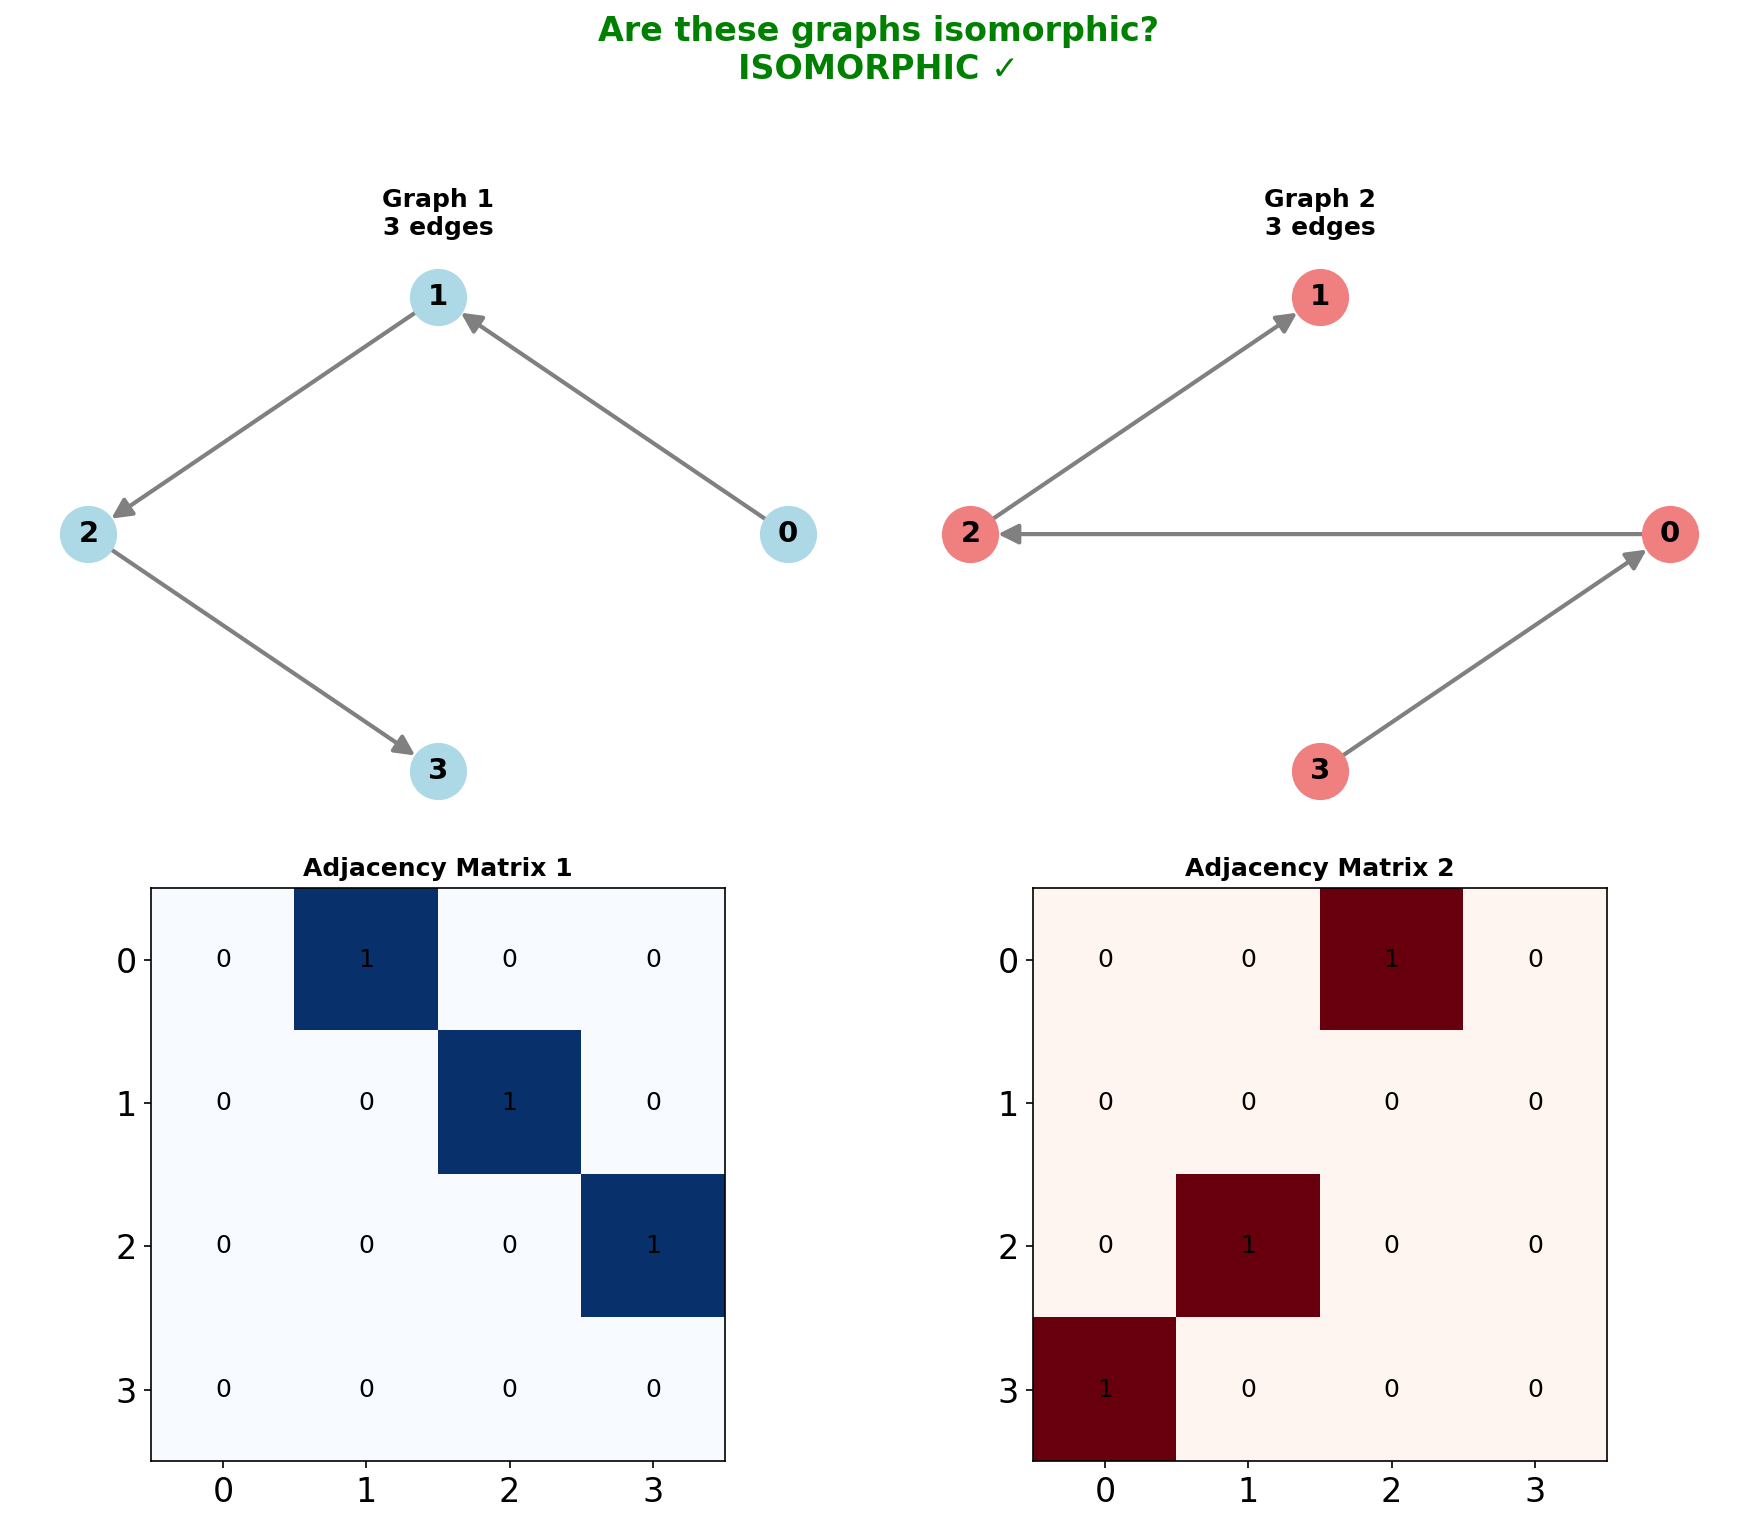

True

In [6]:
# Example 1: Two isomorphic graphs (same structure, different labeling)
print('Example 1: Same chain structure with different node labels')
print('=' * 60)
edges_1a = [(0, 1), (1, 2), (2, 3)]  # Chain: 0→1→2→3
edges_1b = [(3, 0), (0, 2), (2, 1)]  # Chain: 3→0→2→1 (same structure!)
check_isomorphism(edges_1a, edges_1b)


Example 2: Different structures


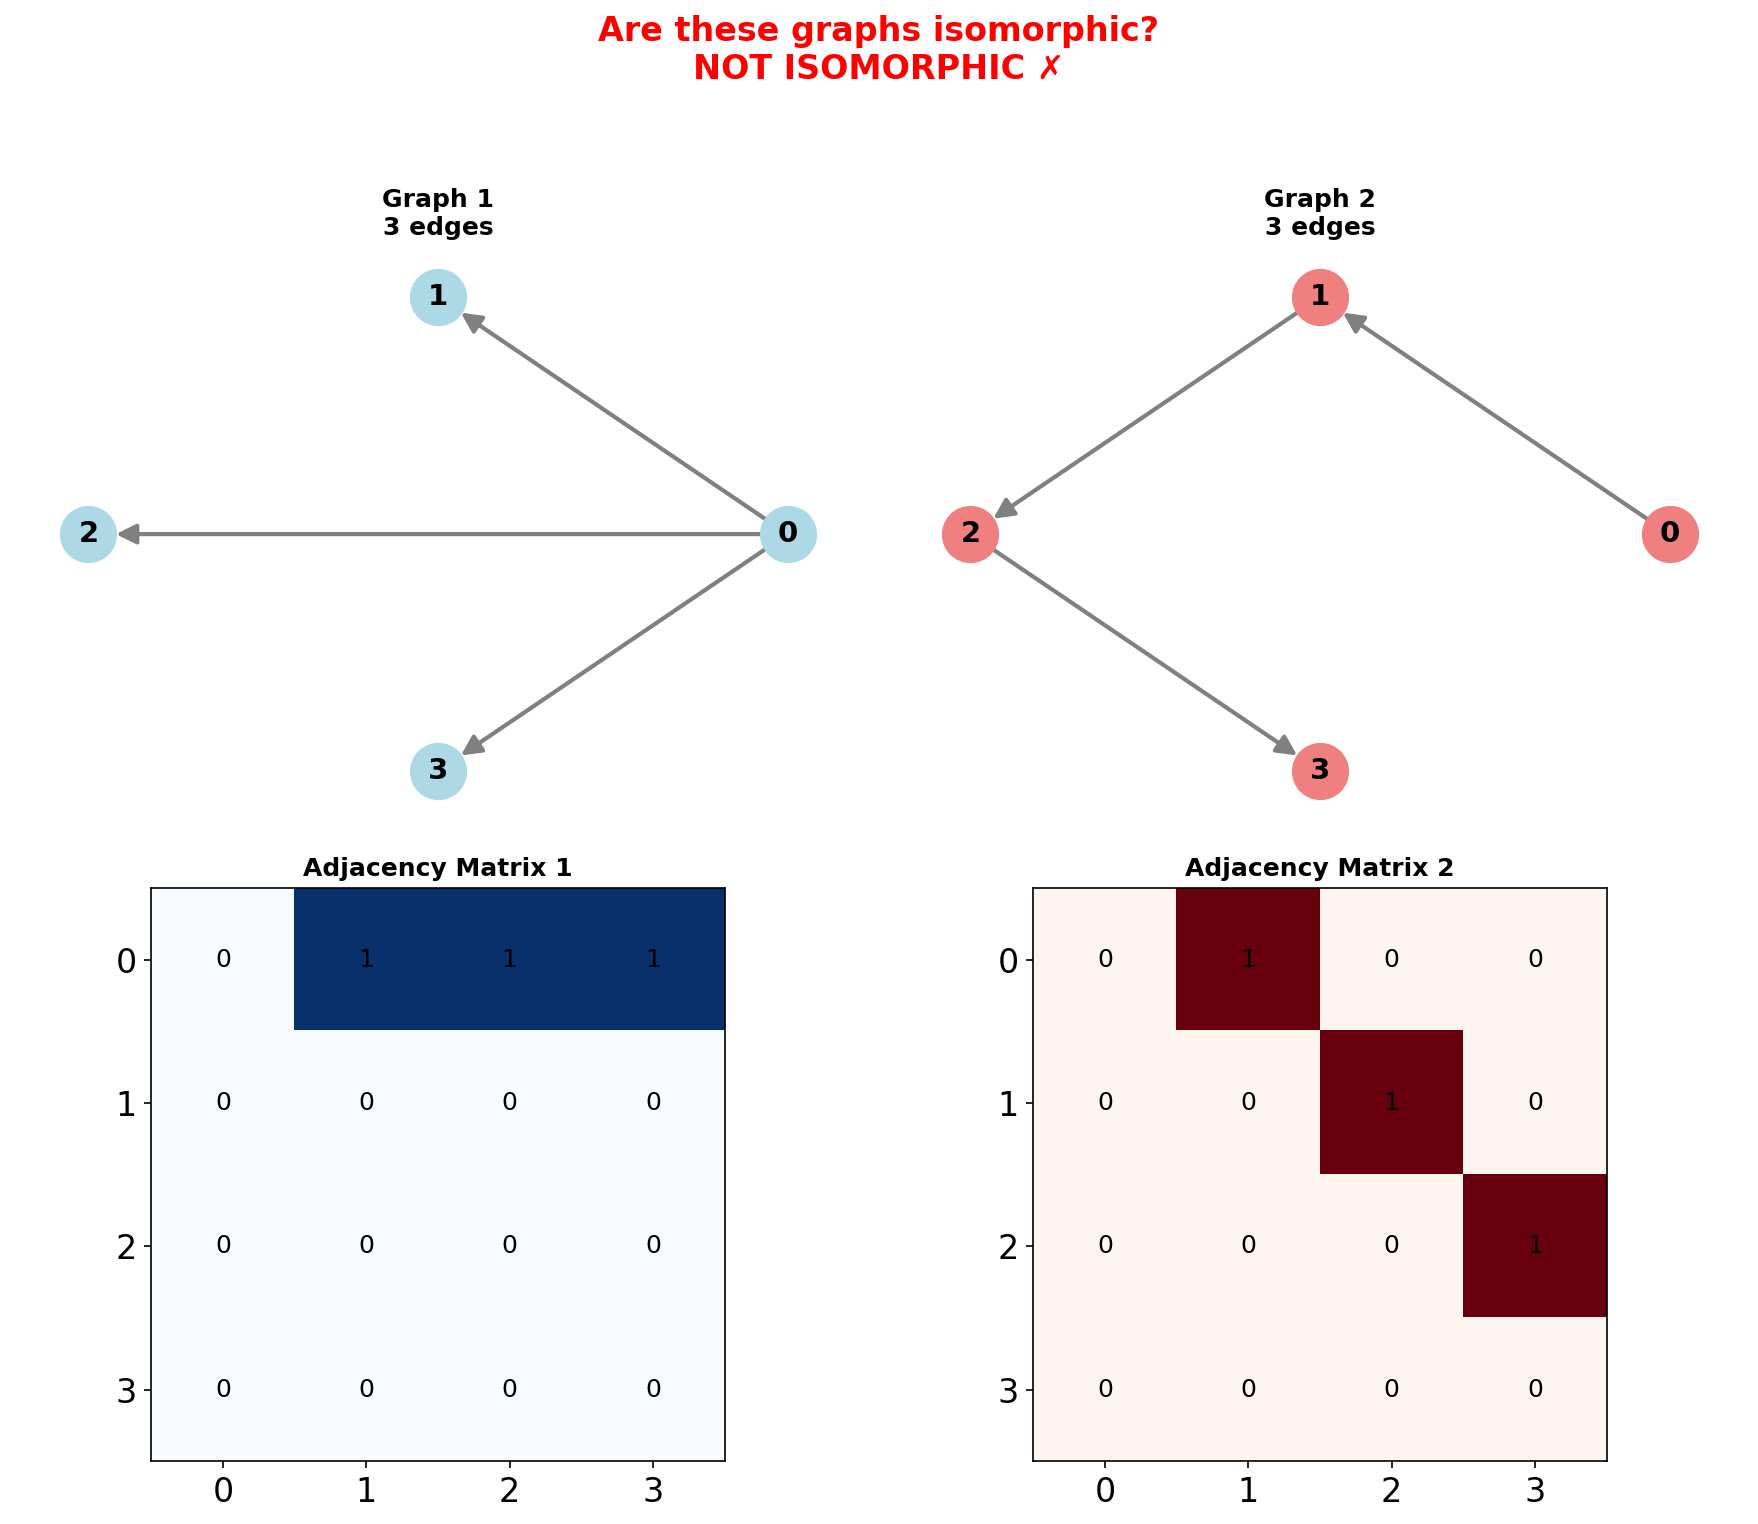

False

In [7]:
# Example 2: Two non-isomorphic graphs
print('\nExample 2: Different structures')
print('=' * 60)
edges_2a = [(0, 1), (0, 2), (0, 3)]  # Star: 0 points to all others
edges_2b = [(0, 1), (1, 2), (2, 3)]  # Chain: 0→1→2→3
check_isomorphism(edges_2a, edges_2b)

### ✏️ Exercise 3.1
> Modify the edge lists above and re-run to explore isomorphism!

### 📌 Note 3.1: Subgraph detection is NP-hard 

1. **Subgraph isomorphism is NP-complete**: Generally checking if a pattern exists in a graph is computationally intractable

2. **Combinatorial explosion**: For n-node directed graphs, the number of possible isomorphisms (motifs) explodes:
   - 3 nodes: up to 64 configurations → **16 unique isomophisms (motifs)** (triads)
   - 4 nodes: up to 4,096 configurations → **218 unique isomophisms (motifs)**
   - 5 nodes: up to 1,048,576 configurations → **9,608 unique isomophisms (motifs)** 
   
Reference: 
[Curto et al. (2019)](https://arxiv.org/abs/1902.10270)

-> We will focus on 3-node motifs (Triads) for the rest of this tutorial!

## 3.2 Raw Motif Counts

✓ Loaded pre-computed motif results
  Dataset: fafb_783_central_complex
  Nodes: 2772
  Edges: 262544


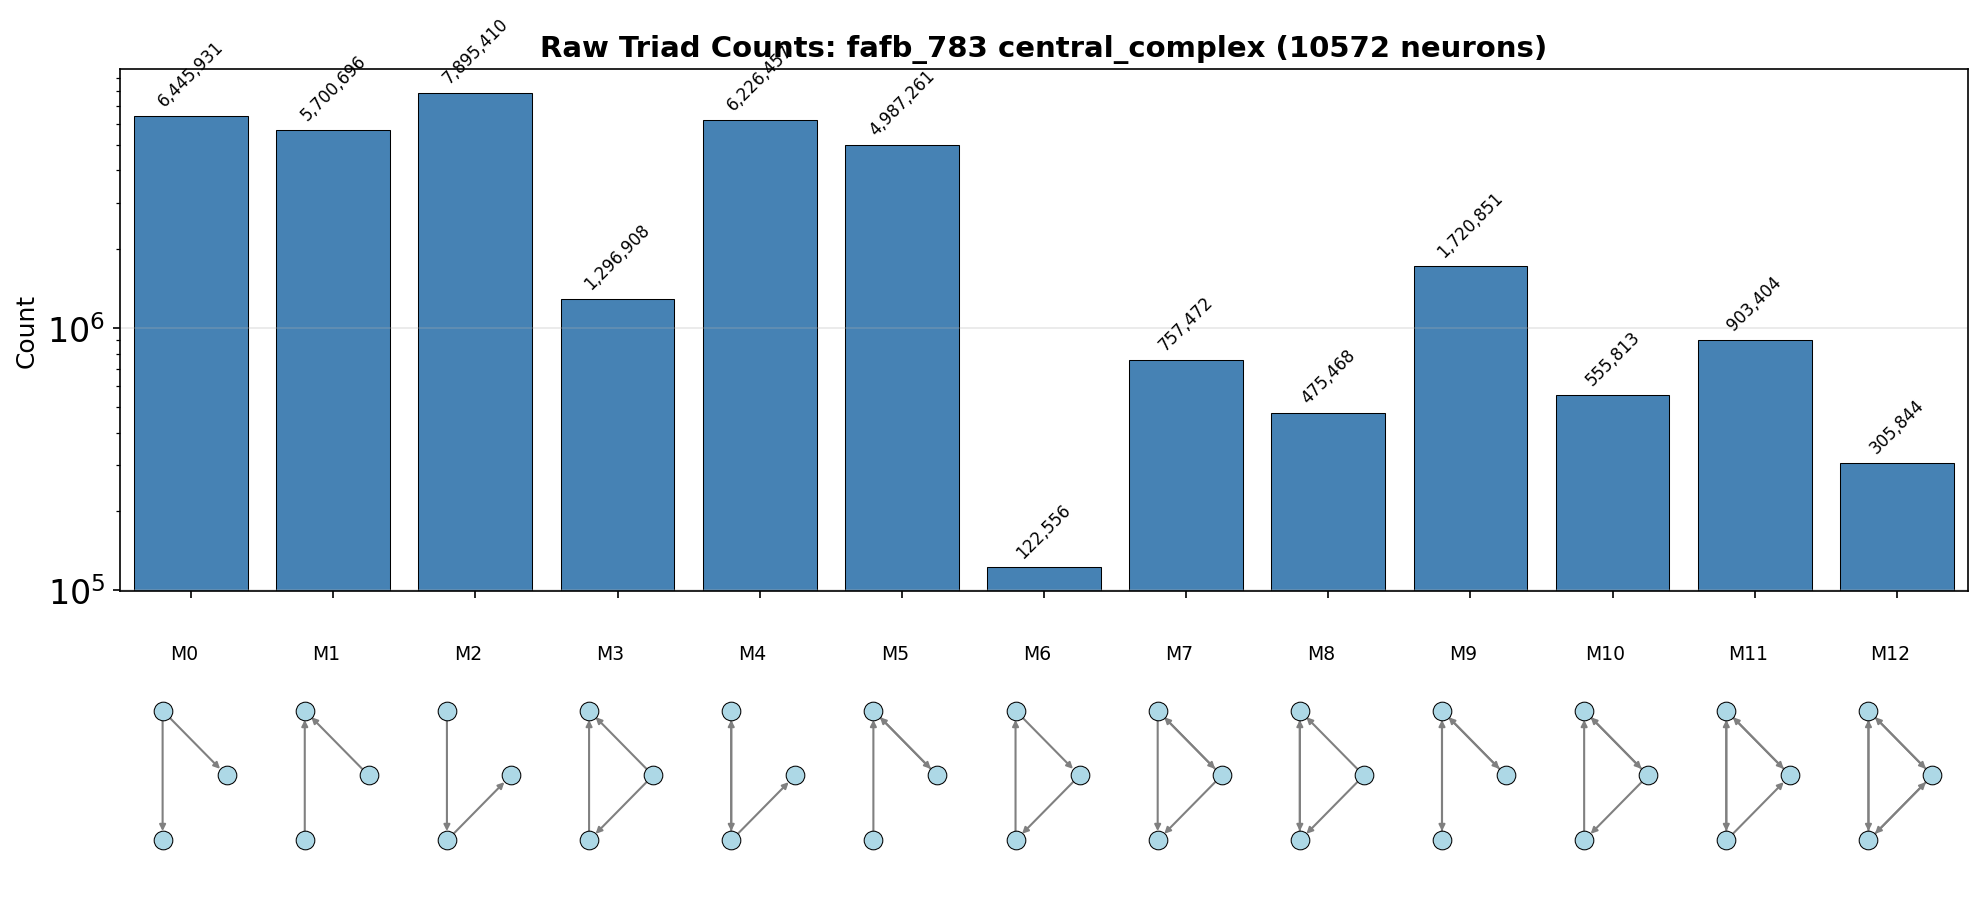

In [8]:
# [PLACEHOLDER] Load pre-computed motif significance results for real connectome
# This will be generated in section 3.4 and saved to data/motif_significance_full_connectome.pkl
import os
import pickle
from IPython.display import Image, display

FULL_CONNECTOME_PATH = 'data/motif_significance_full_connectome.pkl'
MOTIF_FIG_PATH = 'imgs/fig_connectome_raw_motif_counts.png'

if os.path.exists(FULL_CONNECTOME_PATH):
    with open(FULL_CONNECTOME_PATH, 'rb') as f:
        precomputed = pickle.load(f)
    print('✓ Loaded pre-computed motif results')
    print(f"  Dataset: {precomputed.get('dataset', 'unknown')}")
    print(f"  Nodes: {precomputed.get('n_nodes', 'unknown')}")
    print(f"  Edges: {precomputed.get('n_edges', 'unknown')}")
    
    # Display the pre-computed figure #TODO: fis the figure!!!
    if os.path.exists(MOTIF_FIG_PATH):
        display(Image(filename=MOTIF_FIG_PATH))
    else:
        print(f'⚠️ Figure not found: {MOTIF_FIG_PATH}')
else:
    print('⚠️ Pre-computed results not found.')
    print('   Run section 3.4 first, then return here to see the motivation figure.')
    print(f'   Expected path: {FULL_CONNECTOME_PATH}')

The graph above seems to suggest interesting patterns, e.g. over-presence of divergent and convergent motifs. Could we start drawing conclusions based on these?

**Not yet!** Before interpreting real connectome results, we need to build intuition about what motif counts look like in *random* networks, so that we don't mistake random noise for biological insights.

Let's use simple random graphs (Erdős-Rényi) as toy models to see *WHY* null random networks are important:

In [9]:
from plots import plot_motif_counts, align_triad_counts, nx_to_gt, gt_to_nx
import graph_tool.all as gt

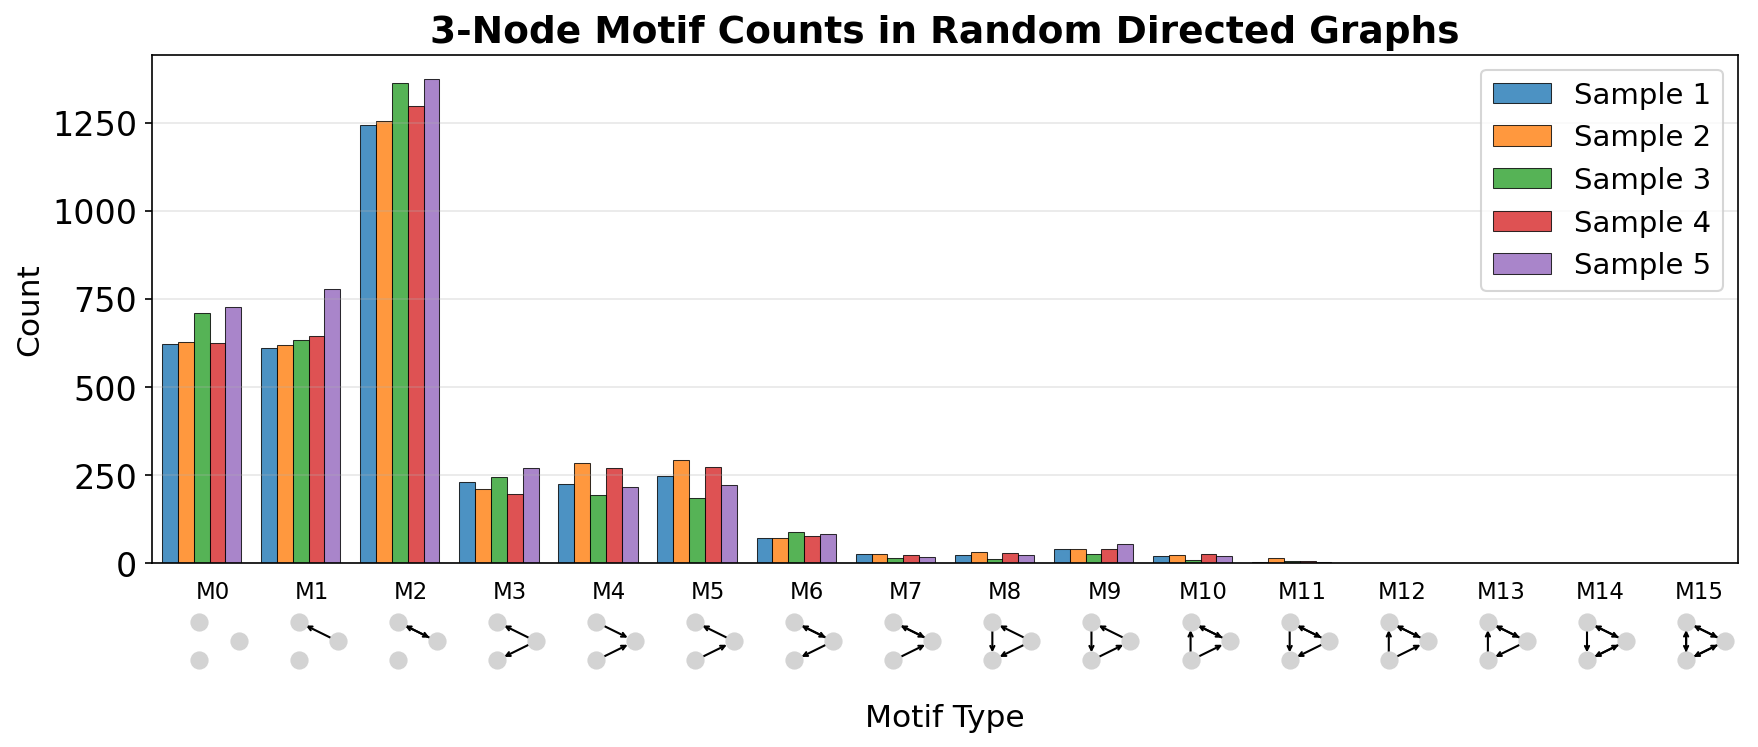

In [10]:
# [FIGURE] Demonstration: Random networks have non-uniform motif distributions
# Generate random graphs and count motifs using graph-tool
n_samples = 5
sampled_ERs = [nx.gnp_random_graph(50, 0.15, seed=100+i, directed=True) for i in range(n_samples)]

# Count 3-node motifs in each sampled graph
motif_data = [gt.motifs(nx_to_gt(G)[0], k=3) for G in sampled_ERs]

# Align counts to 16 triad classes
counts, motif_graphs = align_triad_counts(motif_data)

# Create dict with each sample as separate entry
counts_dict = {f'Sample {i+1}': counts[i] for i in range(n_samples)}

# Plot - each sample gets its own colored bar
fig = plot_motif_counts(
    counts_dict,
    motif_graphs=motif_graphs,
    title='3-Node Motif Counts in Random Directed Graphs',
    figsize=(12, 5), 
    fontsize = 15
)
plt.show()

### 🎯 Take-home 3.2: Raw Motif Counts are Meaningless

Even in **purely random networks**, motif counts are **not uniformly distributed**. Some motif types are inherently more likely to appear by chance.

**Key insight:** The distribution of motifs is NOT uniform - this is crucial to appreciate why we need null models!

This means:
- You **cannot** compare raw counts between motif types (e.g., "we found more triangles than chains")
- You **cannot** compare raw counts across networks of different sizes (more on this later)
- 📌 You **must** compare against a proper null model to determine significance

## 3.3 Null Models: Let's rewire!

To determine if a motif is **significantly enriched**, we need to compare against a **null model** - a randomized version of our network that preserves certain properties.

In [11]:
# Use one of the 5 sampled random graphs as our reference
G_original = sampled_ERs[0].copy()
print(f'Reference graph: {G_original.number_of_nodes()} nodes, {G_original.number_of_edges()} edges')
print(f'Density: {nx.density(G_original):.3f}')

# Convert to graph-tool for rewiring
G_original_gt, node_map = nx_to_gt(G_original)

# Count motifs in original
motifs_orig, counts_orig = gt.motifs(G_original_gt, k=3)
counts_orig_aligned, _ = align_triad_counts([(motifs_orig, counts_orig)])
counts_orig_aligned = counts_orig_aligned[0]

# Color scheme
COLOR_ORIGINAL = '#1f77b4'
COLOR_NULL = '#ff7f0e'

def plot_null_comparison(G_orig, G_null, null_name, counts_orig, counts_null, motif_graphs):
    """Compare original and null model."""
    
    # Create figure with more space between subplots
    fig = plt.figure(figsize=(28, 9))
    
    # Manual positioning: [left, bottom, width, height]
    # Column 1: Networks (stacked)
    ax_net_orig = fig.add_axes([0.02, 0.52, 0.18, 0.42])
    ax_net_null = fig.add_axes([0.02, 0.06, 0.18, 0.42])
    
    # Column 2: Scatter with marginals
    ax_scatter = fig.add_axes([0.26, 0.15, 0.22, 0.65])
    ax_hist_top = fig.add_axes([0.26, 0.82, 0.22, 0.12])
    ax_hist_right = fig.add_axes([0.49, 0.15, 0.04, 0.65])
    
    # Column 3: Degree correlation
    ax_corr = fig.add_axes([0.60, 0.15, 0.17, 0.75])
    
    # Column 4: Motif counts
    ax_motif = fig.add_axes([0.82, 0.15, 0.16, 0.75])
    
    pos = nx.spring_layout(G_orig, seed=42)
    
    # Get degree data
    in_degs_orig = np.array([G_orig.in_degree(n) for n in G_orig.nodes()])
    out_degs_orig = np.array([G_orig.out_degree(n) for n in G_orig.nodes()])
    in_degs_null = np.array([G_null.in_degree(n) for n in G_null.nodes()])
    out_degs_null = np.array([G_null.out_degree(n) for n in G_null.nodes()])
    max_deg = max(max(in_degs_orig), max(out_degs_orig), max(in_degs_null), max(out_degs_null)) + 1
    
    # === Column 1: Networks ===
    nx.draw(G_orig, pos, ax=ax_net_orig, 
            node_color='white', node_size=80, edgecolors=COLOR_ORIGINAL, linewidths=1.5,
            arrows=True, arrowsize=8, edge_color=COLOR_ORIGINAL,
            width=1.0, alpha=0.8, with_labels=True, font_size=10, font_color='black')
    ax_net_orig.set_title(f'Original ({G_orig.number_of_edges()} edges)', 
                          fontsize=16, fontweight='bold', color=COLOR_ORIGINAL)
    
    nx.draw(G_null, pos, ax=ax_net_null,
            node_color='white', node_size=80, edgecolors=COLOR_NULL, linewidths=1.5,
            arrows=True, arrowsize=8, edge_color=COLOR_NULL,
            width=1.0, alpha=0.8, with_labels=True, font_size=10, font_color='black')
    ax_net_null.set_title(f'{null_name} ({G_null.number_of_edges()} edges)', 
                          fontsize=16, fontweight='bold', color=COLOR_NULL)
    
    # === Column 2: Scatter + marginals ===
    ax_scatter.scatter(in_degs_orig, out_degs_orig, c=COLOR_ORIGINAL, s=60, alpha=0.6,
               edgecolor='white', linewidth=0.5, label='Original', zorder=2)
    ax_scatter.scatter(in_degs_null, out_degs_null, c=COLOR_NULL, s=60, alpha=0.6,
               edgecolor='white', linewidth=0.5, label=null_name, zorder=3)
    ax_scatter.plot([0, max_deg], [0, max_deg], 'k--', alpha=0.3, linewidth=1, zorder=1)
    ax_scatter.set_xlabel('In-Degree', fontsize=15)
    ax_scatter.set_ylabel('Out-Degree', fontsize=15)
    ax_scatter.set_xlim(-0.5, max_deg)
    ax_scatter.set_ylim(-0.5, max_deg)
    ax_scatter.set_aspect('equal')
    ax_scatter.grid(True, alpha=0.3)
    ax_scatter.legend(loc='upper left', fontsize=13)
    ax_scatter.tick_params(labelsize=13)
    
    # Top marginal
    bins = np.arange(-0.5, max_deg + 0.5, 1)
    ax_hist_top.hist(in_degs_orig, bins=bins, color=COLOR_ORIGINAL, alpha=0.5, edgecolor='black', linewidth=0.3)
    ax_hist_top.hist(in_degs_null, bins=bins, color=COLOR_NULL, alpha=0.5, edgecolor='black', linewidth=0.3)
    ax_hist_top.set_xlim(-0.5, max_deg)
    ax_hist_top.set_title('In-Out Degree', fontsize=16, fontweight='bold')
    ax_hist_top.tick_params(labelbottom=False, labelsize=11)
    
    # Right marginal
    ax_hist_right.hist(out_degs_orig, bins=bins, color=COLOR_ORIGINAL, alpha=0.5, edgecolor='black', linewidth=0.3, orientation='horizontal')
    ax_hist_right.hist(out_degs_null, bins=bins, color=COLOR_NULL, alpha=0.5, edgecolor='black', linewidth=0.3, orientation='horizontal')
    ax_hist_right.set_ylim(-0.5, max_deg)
    ax_hist_right.tick_params(labelleft=False, labelsize=11)
    
    # === Column 3: Degree correlation ===    
    corr_orig = gt.avg_neighbor_corr(nx_to_gt(G_orig)[0], "in", "out")
    corr_null = gt.avg_neighbor_corr(nx_to_gt(G_null)[0], "in", "out")

    ax_corr.errorbar(corr_orig[2][:-1], corr_orig[0], yerr=corr_orig[1], color=COLOR_ORIGINAL, 
                label='Original', capsize=3, markersize=6, alpha=0.8, linewidth=2)

    ax_corr.errorbar(corr_null[2][:-1], corr_null[0], yerr=corr_null[1], color=COLOR_NULL, 
                label=null_name, capsize=3, markersize=6, alpha=0.8, linewidth=2)

    ax_corr.set_xlabel('Source Out-Degree', fontsize=15)
    ax_corr.set_ylabel('Avg Target In-Degree', fontsize=15)
    ax_corr.set_title('Degree Correlation', fontsize=16, fontweight='bold')
    ax_corr.legend(fontsize=13)
    ax_corr.grid(True, alpha=0.3)
    ax_corr.tick_params(labelsize=13)
    
    # === Column 4: Motif counts ===
    x = np.arange(16)
    width = 0.35
    ax_motif.bar(x - width/2, counts_orig, width, label='Original', 
           color=COLOR_ORIGINAL, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax_motif.bar(x + width/2, counts_null, width, label=null_name, 
           color=COLOR_NULL, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax_motif.set_xlabel('Motif Type', fontsize=15)
    ax_motif.set_ylabel('Count', fontsize=15)
    ax_motif.set_title('Motif Counts', fontsize=16, fontweight='bold')
    ax_motif.set_xticks(x)
    ax_motif.set_xticklabels([f'M{i}' for i in range(16)], fontsize=11, rotation=45)
    ax_motif.legend(fontsize=13)
    ax_motif.grid(True, alpha=0.3, axis='y')
    ax_motif.tick_params(labelsize=13)
    
    return fig


Reference graph: 50 nodes, 352 edges
Density: 0.144


### 3.3.1 Erdős-Rényi: Random rewiring preserving density

The **Erdős-Rényi (ER)** null model generates a random graph with:
- Same number of nodes
- Same edge density (probability of connection)

**What it preserves:** Only the overall sparsity/density of the network.

**What it randomizes:** Everything else, including degree distribution.

**Question answered:** *"Is this motif pattern more than just having this many edges?"*

Erdős-Rényi Null Model Comparison
Property                  Original     ER Null     
--------------------------------------------------
Nodes                     50           50          
Edges                     352          395         
Density                   0.1437       0.1612      
Mean in-degree            7.04         7.90        
Mean out-degree           7.04         7.90        
Std in-degree             2.65         2.82        
Std out-degree            2.58         1.96        


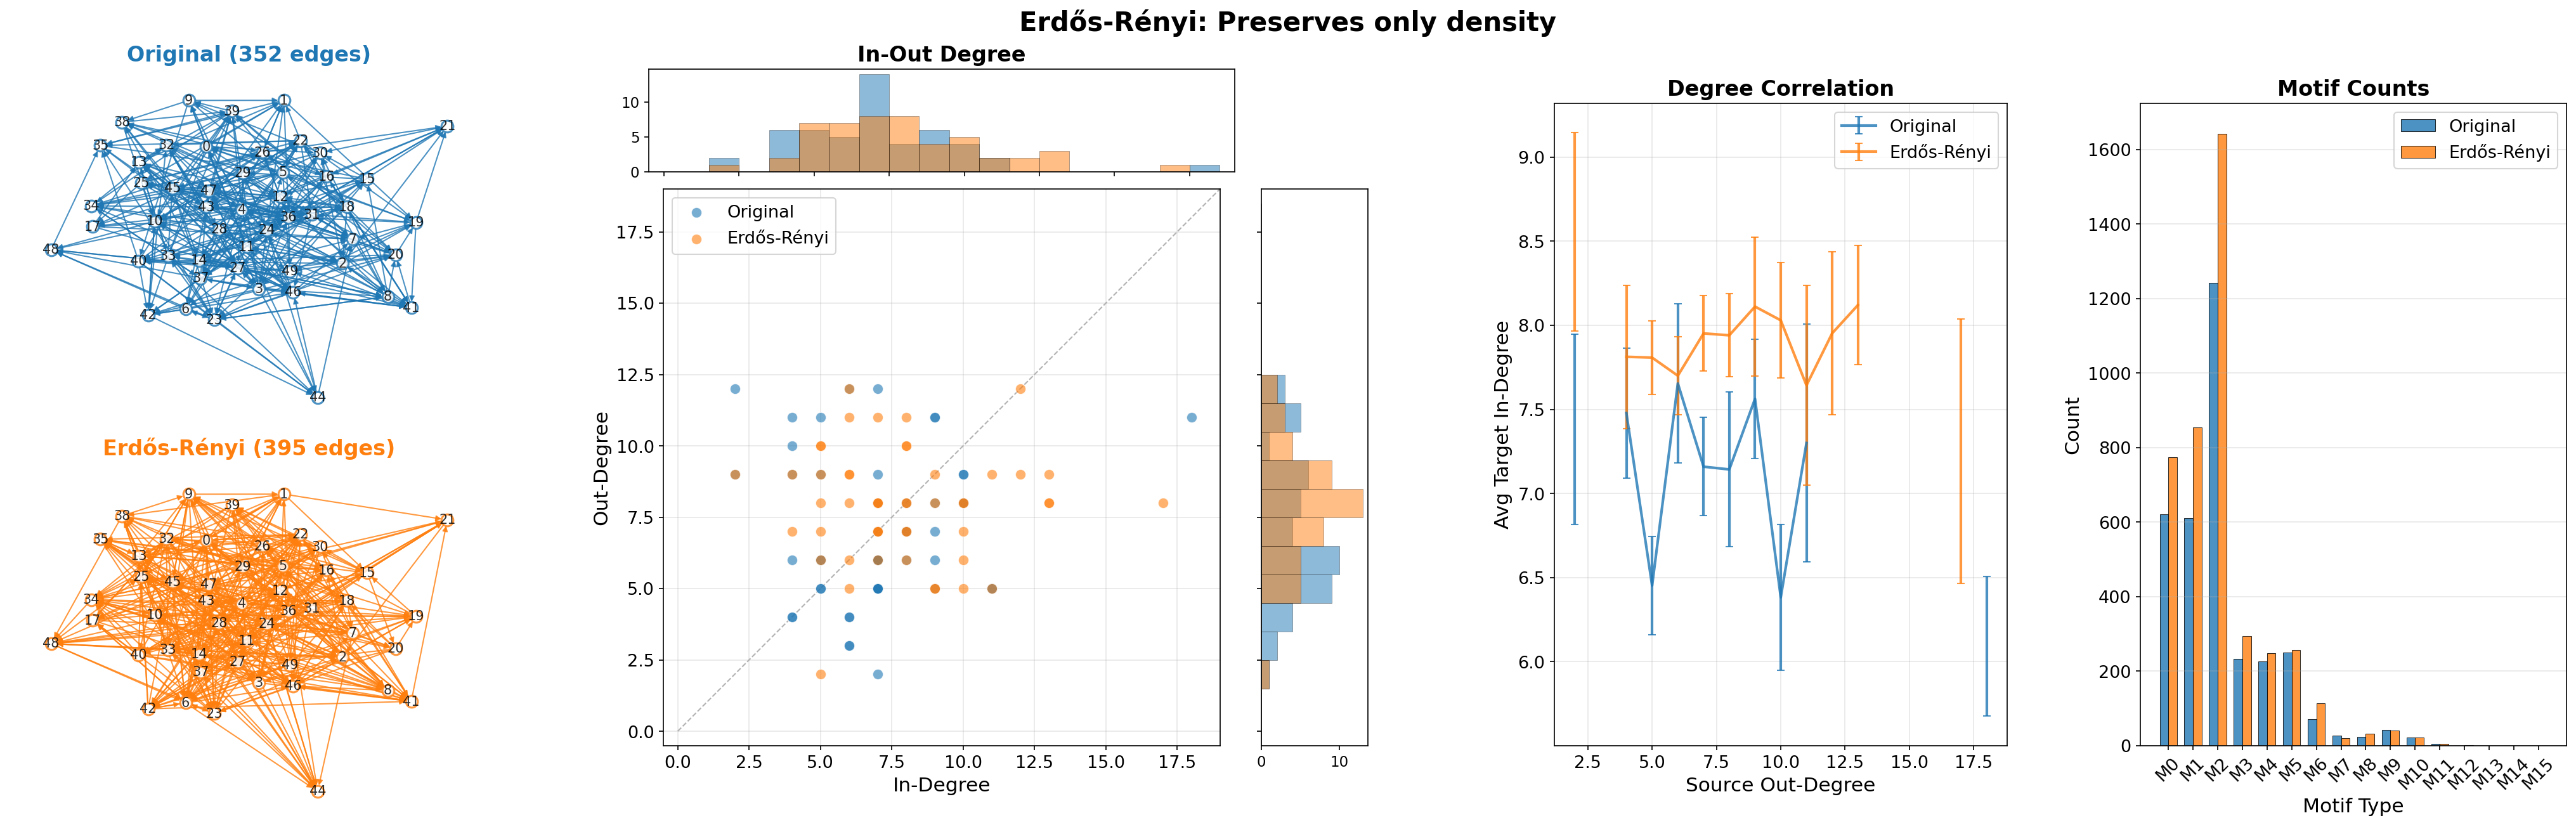


⚠️  Notice: Degree distributions are completely different!


In [12]:
# Generate Erdős-Rényi null model
# Match density of original graph
n_nodes = G_original.number_of_nodes()
n_edges = G_original.number_of_edges()
density = nx.density(G_original)

G_er = nx.gnp_random_graph(n_nodes, density, seed=999, directed=True)

# Count motifs
motifs_er, counts_er = gt.motifs(nx_to_gt(G_er)[0], k=3)
counts_er_aligned, motif_graphs = align_triad_counts([(motifs_er, counts_er)])
counts_er_aligned = counts_er_aligned[0]

# Compare
print('Erdős-Rényi Null Model Comparison')
print('=' * 50)
print(f'{"Property":<25} {"Original":<12} {"ER Null":<12}')
print('-' * 50)
print(f'{"Nodes":<25} {G_original.number_of_nodes():<12} {G_er.number_of_nodes():<12}')
print(f'{"Edges":<25} {G_original.number_of_edges():<12} {G_er.number_of_edges():<12}')
print(f'{"Density":<25} {nx.density(G_original):<12.4f} {nx.density(G_er):<12.4f}')
print(f'{"Mean in-degree":<25} {np.mean([G_original.in_degree(n) for n in G_original.nodes()]):<12.2f} {np.mean([G_er.in_degree(n) for n in G_er.nodes()]):<12.2f}')
print(f'{"Mean out-degree":<25} {np.mean([G_original.out_degree(n) for n in G_original.nodes()]):<12.2f} {np.mean([G_er.out_degree(n) for n in G_er.nodes()]):<12.2f}')
print(f'{"Std in-degree":<25} {np.std([G_original.in_degree(n) for n in G_original.nodes()]):<12.2f} {np.std([G_er.in_degree(n) for n in G_er.nodes()]):<12.2f}')
print(f'{"Std out-degree":<25} {np.std([G_original.out_degree(n) for n in G_original.nodes()]):<12.2f} {np.std([G_er.out_degree(n) for n in G_er.nodes()]):<12.2f}')

# Plot comparison
fig = plot_null_comparison(G_original, G_er, 'Erdős-Rényi', 
                           counts_orig_aligned, counts_er_aligned, motif_graphs)
plt.suptitle('Erdős-Rényi: Preserves only density', fontsize=20, fontweight='bold', y=1.01)
plt.savefig('imgs/fig_3_3_1_erdos_renyi.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n⚠️  Notice: Degree distributions are completely different!')

### 3.3.2 Configuration: Random rewiring preserving degree sequence
The **Configuration Model** generates a random graph with:
- Same number of nodes
- Same degree sequence

**What it preserves:** The degree heterogeneity (hubs remain hubs).

**What it randomizes:** Specific connections between nodes.

**Question answered:** *"Is this motif pattern more than just degree heterogeneity?"*

Configuration Model Comparison
Property                  Original     Config Null 
--------------------------------------------------
Nodes                     50           50          
Edges                     352          352         
Density                   0.1437       0.1437      
Mean in-degree            7.04         7.04        
Mean out-degree           7.04         7.04        
Std in-degree             2.65         2.65        
Std out-degree            2.58         2.58        


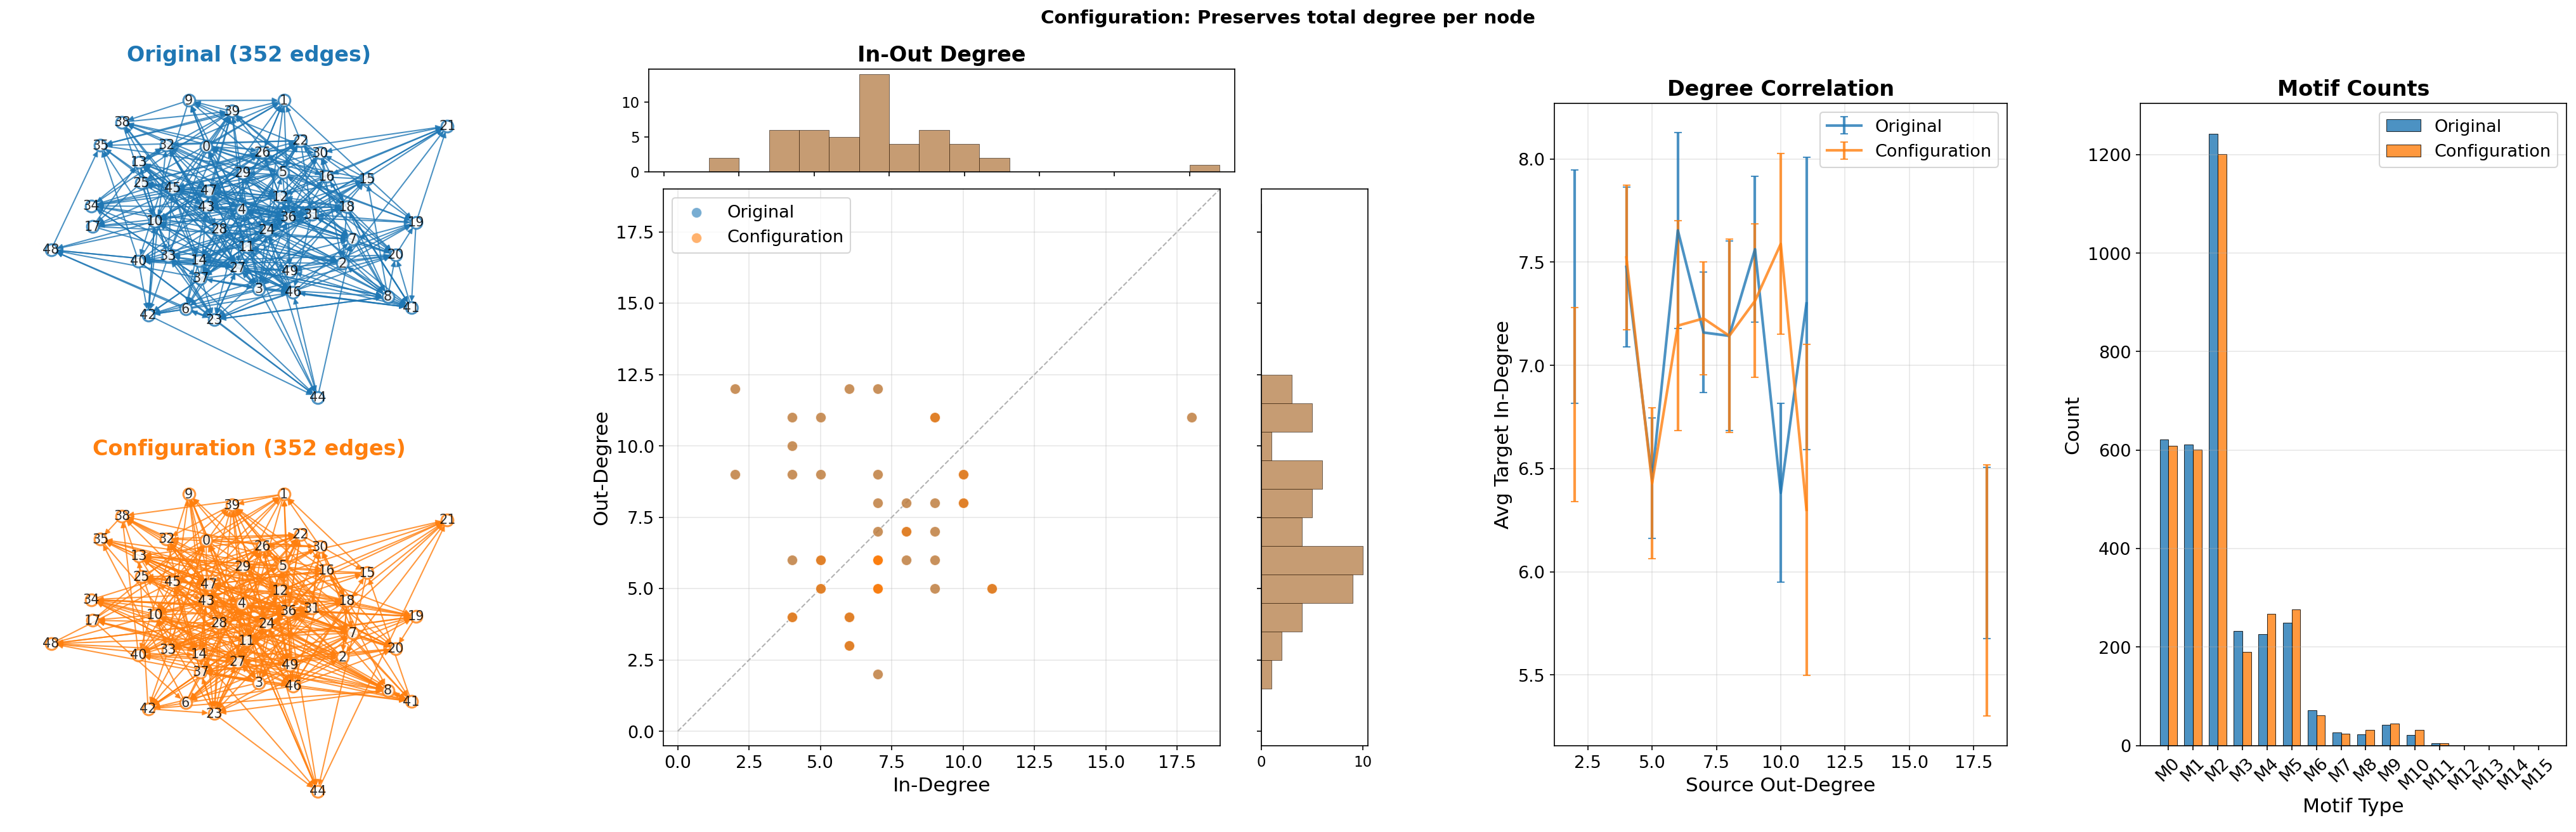


⚠️  Notice: Total degree per node is similar, but in/out correlation may differ!
    A node's neighborhood (1-hop) correlation changes.


In [13]:
# Generate Configuration null model via edge rewiring
G_config_gt = G_original_gt.copy()
gt.random_rewire(G_config_gt, model='configuration', n_iter=100)
G_config = gt_to_nx(G_config_gt)

# Count motifs
motifs_config, counts_config = gt.motifs(G_config_gt, k=3)
counts_config_aligned, _ = align_triad_counts([(motifs_config, counts_config)])
counts_config_aligned = counts_config_aligned[0]

# Compare
print('Configuration Model Comparison')
print('=' * 50)
print(f'{"Property":<25} {"Original":<12} {"Config Null":<12}')
print('-' * 50)
print(f'{"Nodes":<25} {G_original.number_of_nodes():<12} {G_config.number_of_nodes():<12}')
print(f'{"Edges":<25} {G_original.number_of_edges():<12} {G_config.number_of_edges():<12}')
print(f'{"Density":<25} {nx.density(G_original):<12.4f} {nx.density(G_config):<12.4f}')
print(f'{"Mean in-degree":<25} {np.mean([G_original.in_degree(n) for n in G_original.nodes()]):<12.2f} {np.mean([G_config.in_degree(n) for n in G_config.nodes()]):<12.2f}')
print(f'{"Mean out-degree":<25} {np.mean([G_original.out_degree(n) for n in G_original.nodes()]):<12.2f} {np.mean([G_config.out_degree(n) for n in G_config.nodes()]):<12.2f}')
print(f'{"Std in-degree":<25} {np.std([G_original.in_degree(n) for n in G_original.nodes()]):<12.2f} {np.std([G_config.in_degree(n) for n in G_config.nodes()]):<12.2f}')
print(f'{"Std out-degree":<25} {np.std([G_original.out_degree(n) for n in G_original.nodes()]):<12.2f} {np.std([G_config.out_degree(n) for n in G_config.nodes()]):<12.2f}')

# Plot comparison
fig = plot_null_comparison(G_original, G_config, 'Configuration', 
                           counts_orig_aligned, counts_config_aligned, motif_graphs)
plt.suptitle('Configuration: Preserves total degree per node', fontsize=14, fontweight='bold', y=1.01)
plt.savefig('imgs/fig_3_3_2_configuration.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n⚠️  Notice: Total degree per node is similar, but in/out correlation may differ!')
print('    A node\'s neighborhood (1-hop) correlation changes.')

### 3.3.3 Constrained-Configuration: Preserving in & out degree separately

The **Constrained-Configuration Model** generates a random graph with:
- Same number of nodes
- Same degree sequence
- Same in-out degree correlation

**What it preserves:** The "role" of each node (senders vs receivers).

**What it randomizes:** Only the specific wiring pattern.

**Question answered:** *"Is this motif pattern more than what's expected from node roles?"*

This is the **most stringent** null model — if a motif is still significant here, it means the specific connectivity pattern itself is special.

Constrained-Configuration Model Comparison
Property                  Original     Constrained 
--------------------------------------------------
Nodes                     50           50          
Edges                     352          352         
Density                   0.1437       0.1437      
Mean in-degree            7.04         7.04        
Mean out-degree           7.04         7.04        
Std in-degree             2.65         2.65        
Std out-degree            2.58         2.58        


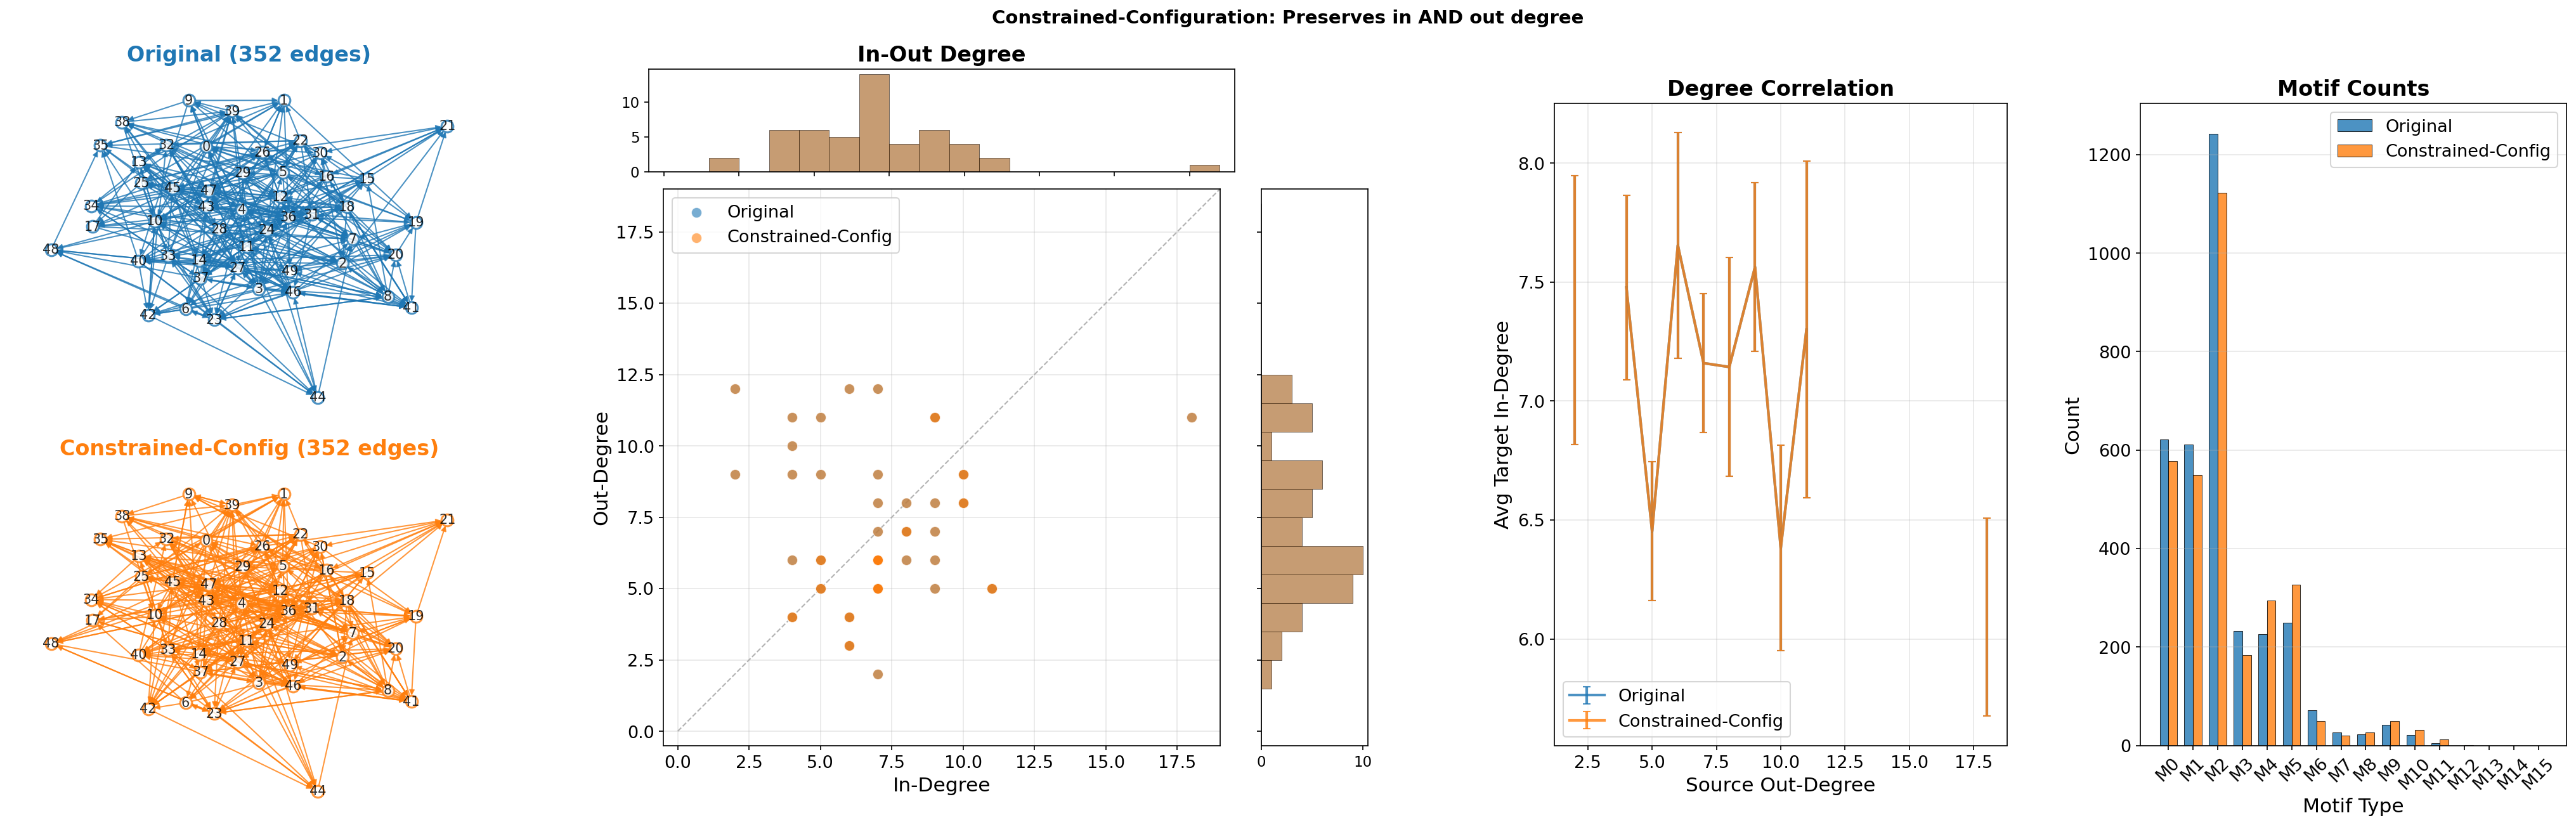


✓ Notice: In-degree AND out-degree distributions are preserved!
  Only the specific wiring pattern differs.
  This is the gold standard for directed network null models.


In [14]:
# Generate Constrained-Configuration null model
G_constrained_gt = G_original_gt.copy()
gt.random_rewire(G_constrained_gt, model='constrained-configuration', n_iter=100)
G_constrained = gt_to_nx(G_constrained_gt)

# Count motifs
motifs_constrained, counts_constrained = gt.motifs(G_constrained_gt, k=3)
counts_constrained_aligned, _ = align_triad_counts([(motifs_constrained, counts_constrained)])
counts_constrained_aligned = counts_constrained_aligned[0]

# Compare
print('Constrained-Configuration Model Comparison')
print('=' * 50)
print(f'{"Property":<25} {"Original":<12} {"Constrained":<12}')
print('-' * 50)
print(f'{"Nodes":<25} {G_original.number_of_nodes():<12} {G_constrained.number_of_nodes():<12}')
print(f'{"Edges":<25} {G_original.number_of_edges():<12} {G_constrained.number_of_edges():<12}')
print(f'{"Density":<25} {nx.density(G_original):<12.4f} {nx.density(G_constrained):<12.4f}')
print(f'{"Mean in-degree":<25} {np.mean([G_original.in_degree(n) for n in G_original.nodes()]):<12.2f} {np.mean([G_constrained.in_degree(n) for n in G_constrained.nodes()]):<12.2f}')
print(f'{"Mean out-degree":<25} {np.mean([G_original.out_degree(n) for n in G_original.nodes()]):<12.2f} {np.mean([G_constrained.out_degree(n) for n in G_constrained.nodes()]):<12.2f}')
print(f'{"Std in-degree":<25} {np.std([G_original.in_degree(n) for n in G_original.nodes()]):<12.2f} {np.std([G_constrained.in_degree(n) for n in G_constrained.nodes()]):<12.2f}')
print(f'{"Std out-degree":<25} {np.std([G_original.out_degree(n) for n in G_original.nodes()]):<12.2f} {np.std([G_constrained.out_degree(n) for n in G_constrained.nodes()]):<12.2f}')

# Plot comparison
fig = plot_null_comparison(G_original, G_constrained, 'Constrained-Config', 
                           counts_orig_aligned, counts_constrained_aligned, motif_graphs)
plt.suptitle('Constrained-Configuration: Preserves in AND out degree', fontsize=14, fontweight='bold', y=1.01)
plt.savefig('imgs/fig_3_3_3_constrained_configuration.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Notice: In-degree AND out-degree distributions are preserved!')
print('  Only the specific wiring pattern differs.')
print('  This is the gold standard for directed network null models.')

### 3.3.4 Motif significance across null models

In [15]:
# Motif significance analysis using the same graph from rewiring demo
from scipy import stats

print('MOTIF SIGNIFICANCE ANALYSIS')
print('=' * 60)
print(f'Analyzing: G_original ({G_original.number_of_nodes()} nodes, {G_original.number_of_edges()} edges)')
print('Comparing against three null models (30 shuffles each)...')

null_models = ['erdos', 'configuration', 'constrained-configuration']
results_by_model = {}

for model in null_models:
    print(f'  Running {model}...')
    motif_graphs, z_scores = gt.motif_significance(G_original_gt, k=3, n_shuffles=100, shuffle_model=model)
    motifs, counts = gt.motifs(G_original_gt, k=3)
    
    results = {}
    for i, z in enumerate(z_scores):
        if i < len(counts) and counts[i] > 0:
            p = 2 * (1 - stats.norm.cdf(abs(z)))
            results[i] = {'observed': int(counts[i]), 'z_score': float(z), 'p_value': float(p)}
    results_by_model[model] = results

# Print summary table
print('\n' + '=' * 80)
print(f'{"Motif":<8} {"Count":<8} {"ER":<12} {"Config":<12} {"Constrained":<12}')
print('-' * 80)

all_motifs = sorted(set().union(*[r.keys() for r in results_by_model.values()]))
for idx in all_motifs:
    obs = results_by_model['erdos'].get(idx, {}).get('observed', 0)
    z_vals = []
    for model in null_models:
        z = results_by_model[model].get(idx, {}).get('z_score', 0)
        p = results_by_model[model].get(idx, {}).get('p_value', 1)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
        z_vals.append(f'{z:>6.2f}{sig:<3}')
    print(f'M{idx:<7} {obs:<8} {z_vals[0]:<12} {z_vals[1]:<12} {z_vals[2]:<12}')

print('\nSignificance: * p<0.05, ** p<0.01, *** p<0.001')
print('Positive z = over-represented, Negative z = under-represented')


MOTIF SIGNIFICANCE ANALYSIS
Analyzing: G_original (50 nodes, 352 edges)
Comparing against three null models (30 shuffles each)...
  Running erdos...
  Running configuration...
  Running constrained-configuration...

Motif    Count    ER           Config       Constrained 
--------------------------------------------------------------------------------
M0       621       -0.88        -1.09         0.35      
M1       611       -1.02        -1.22         0.48      
M2       1242      -0.98        -0.87         0.43      
M3       232        0.49         0.34         0.69      
M4       226        0.29         0.33        -1.39      
M5       249        0.98         0.65        -1.00      
M6       71        -0.45        -0.29         1.18      
M7       27         2.05*        2.00*        2.47*     
M8       23         1.04         0.49        -0.19      
M9       42         1.08         0.67        -0.26      
M10      21         0.36         0.13        -0.58      
M11      5         

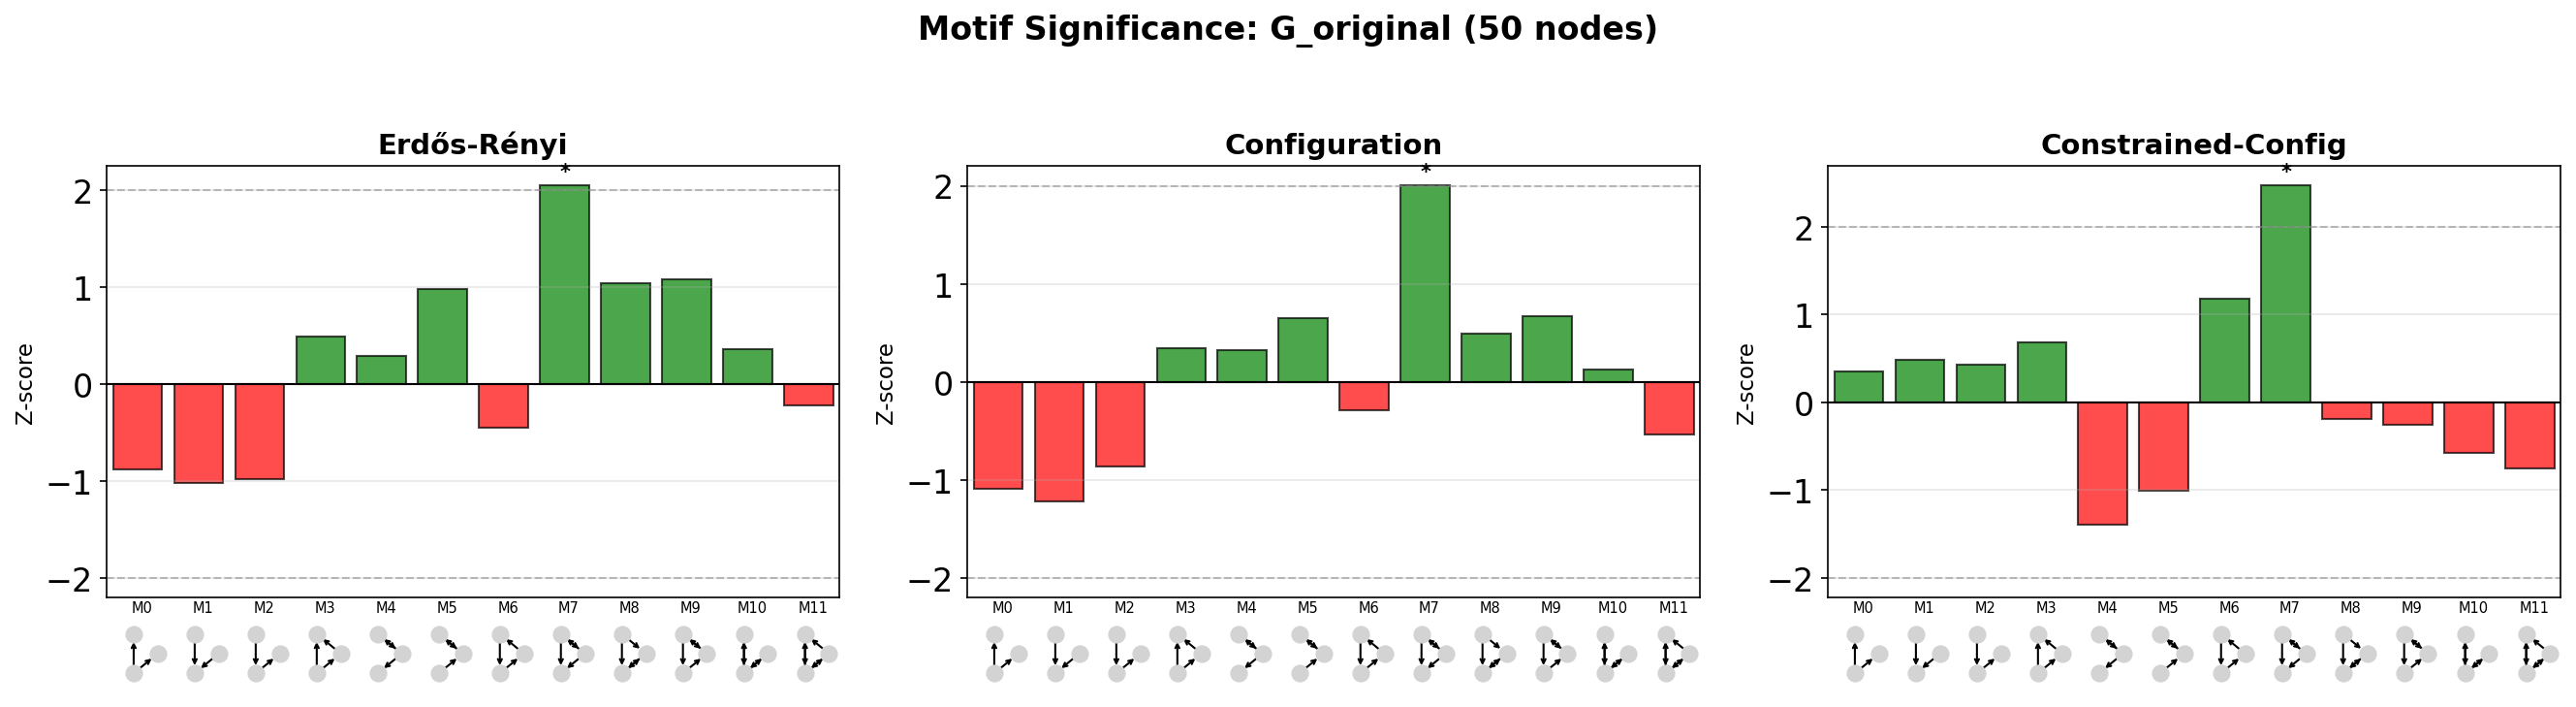

In [16]:
# [FIGURE] Z-score visualization comparing null models
from plots import plot_motif_significance, gt_motif_to_nx

# Get motif graphs for x-axis visualization
motifs_for_plot, _ = gt.motifs(G_original_gt, k=3)
motif_graphs_nx = [gt_motif_to_nx(m) for m in motifs_for_plot]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_motif_significance(
    results_by_model,
    motif_graphs_nx,
    null_models=['erdos', 'configuration', 'constrained-configuration'],
    axes=axes,
    show_legend=True
)

axes[0].set_title('Erdős-Rényi', fontsize=14, fontweight='bold')
axes[1].set_title('Configuration', fontsize=14, fontweight='bold')
axes[2].set_title('Constrained-Config', fontsize=14, fontweight='bold')

plt.suptitle(f'Motif Significance: G_original ({G_original.number_of_nodes()} nodes)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('imgs/fig_3_3_4_motif_significance.png', dpi=150, bbox_inches='tight')
plt.show()


### 🎯 Take-home 3.3: Motif Significance Analysis - Choosing the Null Model

| Model | Preserves | Use case |
|-------|-----------|----------|
| `Erdős–Rényi` | Edge count | When only global density is of interest |
| `configuration` | Degree sequence | Standard choice |
| `constrained-configuration` | Degree sequence + correlations | Controlling for assortativity |

Most analyses use `configuration` to ask: "are motifs significant beyond what the degree sequence alone produces?"

### 📌 Notes 3.3: Uniform Sampling of Graphs is HARD

Graph-tool uses MCMC (edge swaps) to generate null samples. Two parameters matter:

- **`n_shuffles`**: number of null samples (estimation precision)
- **`n_iter`**: swap iterations per sample (sampling quality)

**Key insight:** More samples cannot fix poor mixing. With insufficient `n_iter`, samples stay correlated with the starting graph → underestimated variance → inflated z-scores.

**Diagnose mixing:** Increase `n_iter` until null distribution variance stabilizes.

**Note:** `motif_significance()` doesn't expose `n_iter`. Use `random_rewire()` for full control.

### References

- Milo et al. (2002). "Network Motifs: Simple Building Blocks of Complex Networks." *Science*, 298(5594), 824-827.
- Milo et al. (2004). "Superfamilies of Evolved and Designed Networks." *Science*, 303(5663), 1538-1542.

### ✏️ Exercise: Run Motif Significance on the Real Connectome

Now try running motif significance analysis on the full connectome! 

**Decisions:**
- Which null model do you want to use?
- How many shuffles do you want to do? How do you decide?

**Warning:** This will take a while (several minutes) because:
- The connectome has >2,500 nodes and ~35,000 edges
- Each null model shuffle requires counting all triads
- We need many shuffles for reliable statistics

**Questions to consider:**
1. Which motifs are significantly over/under-represented?
2. How do the results compare to our toy example?
3. Does the choice of null model (ER vs configuration vs constrained-configuration) change the conclusions?

In [17]:
# ✏️ YOUR CODE HERE: Run motif significance on the real connectome
# Hint: Use the code snippet from the markdown cell above

# G_connectome_gt, _ = nx_to_gt(G_connectome)
# ...

We will load the pre-computed results here. 

In [18]:
# Start connectome motif analysis in background (OR load pre-computed results)
import threading
import time
import pickle
import os

# Storage for results
connectome_results = {'status': 'not_started', 'results': None, 'elapsed': None}

# Check if pre-computed results exist
CONNECTOME_MOTIF_PATH = 'data/motif_significance_full_connectome.pkl'

if os.path.exists(CONNECTOME_MOTIF_PATH):
    # Load pre-computed results
    with open(CONNECTOME_MOTIF_PATH, 'rb') as f:
        saved = pickle.load(f)
    
    connectome_results['status'] = 'completed'
    connectome_results['elapsed'] = saved.get('elapsed_seconds', 0)
    connectome_results['z_scores'] = saved['z_scores']
    connectome_results['counts'] = saved['counts']
    connectome_results['motif_graphs'] = saved['motif_graphs']
    
    print('=' * 70)
    print('LOADED PRE-COMPUTED CONNECTOME MOTIF RESULTS')
    print('=' * 70)
    print(f"  File: {CONNECTOME_MOTIF_PATH}")
    print(f"  Dataset: {saved.get('dataset', 'unknown')}")
    print(f"  Nodes: {saved.get('n_nodes', 'unknown')}")
    print(f"  Edges: {saved.get('n_edges', 'unknown')}")
    print(f"  Null model: {saved.get('shuffle_model', 'unknown')}")
    print(f"  Original computation time: {saved.get('elapsed_seconds', 0):.1f} seconds")

else:
    # Run analysis in background
    def run_connectome_motif_analysis():
        """Run motif significance analysis on full connectome."""
        global connectome_results
        connectome_results['status'] = 'running'
        
        try:
            start = time.time()
            
            # Convert to graph-tool
            G_conn_gt, _ = nx_to_gt(G_connectome)
            print(f'  Converted: {G_conn_gt.num_vertices()} nodes, {G_conn_gt.num_edges()} edges')
            
            # Run significance analysis with configuration
            motif_graphs_conn, z_scores_conn = gt.motif_significance(
                G_conn_gt, k=3, n_shuffles=100, shuffle_model='configuration'
            )
            
            # Get observed counts
            motifs_conn, counts_conn = gt.motifs(G_conn_gt, k=3)
            
            elapsed = time.time() - start
            
            # Store results
            connectome_results['status'] = 'completed'
            connectome_results['elapsed'] = elapsed
            connectome_results['motif_graphs'] = [gt_motif_to_nx(m) for m in motif_graphs_conn]
            connectome_results['z_scores'] = z_scores_conn
            connectome_results['counts'] = counts_conn
            
            print(f'\nBACKGROUND TASK COMPLETED in {elapsed:.1f} seconds')
            
        except Exception as e:
            connectome_results['status'] = 'error'
            connectome_results['error'] = str(e)
            print(f'\nBACKGROUND TASK FAILED: {e}')
    
    # Start background thread
    print('=' * 70)
    print('STARTING BACKGROUND ANALYSIS: Full Connectome Motif Significance')
    print('=' * 70)
    print(f'  Network: {G_connectome.number_of_nodes()} nodes, {G_connectome.number_of_edges()} edges')
    print(f'  Null model: configuration (100 shuffles)')
    print(f'  Expected time: ~5-10 minutes')
    print()
    print('Continue with the tutorial while this runs...')
    print('   We will analyze the results in section 3.4')
    
    bg_thread = threading.Thread(target=run_connectome_motif_analysis)
    bg_thread.start()

LOADED PRE-COMPUTED CONNECTOME MOTIF RESULTS
  File: data/motif_significance_full_connectome.pkl
  Dataset: fafb_783_central_complex
  Nodes: 2772
  Edges: 262544
  Null model: configuration
  Original computation time: 39564.5 seconds


## 3.4 Analyze Full Connectome Results

In [19]:
# Check status of background connectome analysis

print('=' * 70)
print('CHECKING BACKGROUND ANALYSIS STATUS')
print('=' * 70)

if connectome_results['status'] == 'completed':
    print(f"✅ Analysis completed in {connectome_results['elapsed']:.1f} seconds")
    print(f"   Found {len(connectome_results['z_scores'])} motif types")
    
elif connectome_results['status'] == 'running':
    print('⏳ Analysis still running...')
    print('   Waiting for completion (this may take a few minutes)...')
    
    # Wait for thread to complete
    bg_thread.join()
    
    if connectome_results['status'] == 'completed':
        print(f"\n✅ Analysis completed in {connectome_results['elapsed']:.1f} seconds")
    else:
        print(f"\n❌ Analysis failed: {connectome_results.get('error', 'unknown error')}")
        
elif connectome_results['status'] == 'error':
    print(f"❌ Analysis failed: {connectome_results['error']}")
    
else:
    print('⚠️ Background analysis was not started.')
    print('   Go back to section 3.4 and run the cell that starts the background thread.')

CHECKING BACKGROUND ANALYSIS STATUS
✅ Analysis completed in 39564.5 seconds
   Found 13 motif types


RAW MOTIF COUNTS: Full Connectome (10572 nodes)
Motif    Count           % of Total
------------------------------------------------------------
M0       6,445,931        17.24%
M1       5,700,696        15.24%
M2       7,895,410        21.11%
M3       1,296,908         3.47%
M4       6,226,457        16.65%
M5       4,987,261        13.34%
M6       122,556           0.33%
M7       757,472           2.03%
M8       475,468           1.27%
M9       1,720,851         4.60%
M10      555,813           1.49%
M11      903,404           2.42%
M12      305,844           0.82%
------------------------------------------------------------
TOTAL    37,394,071     


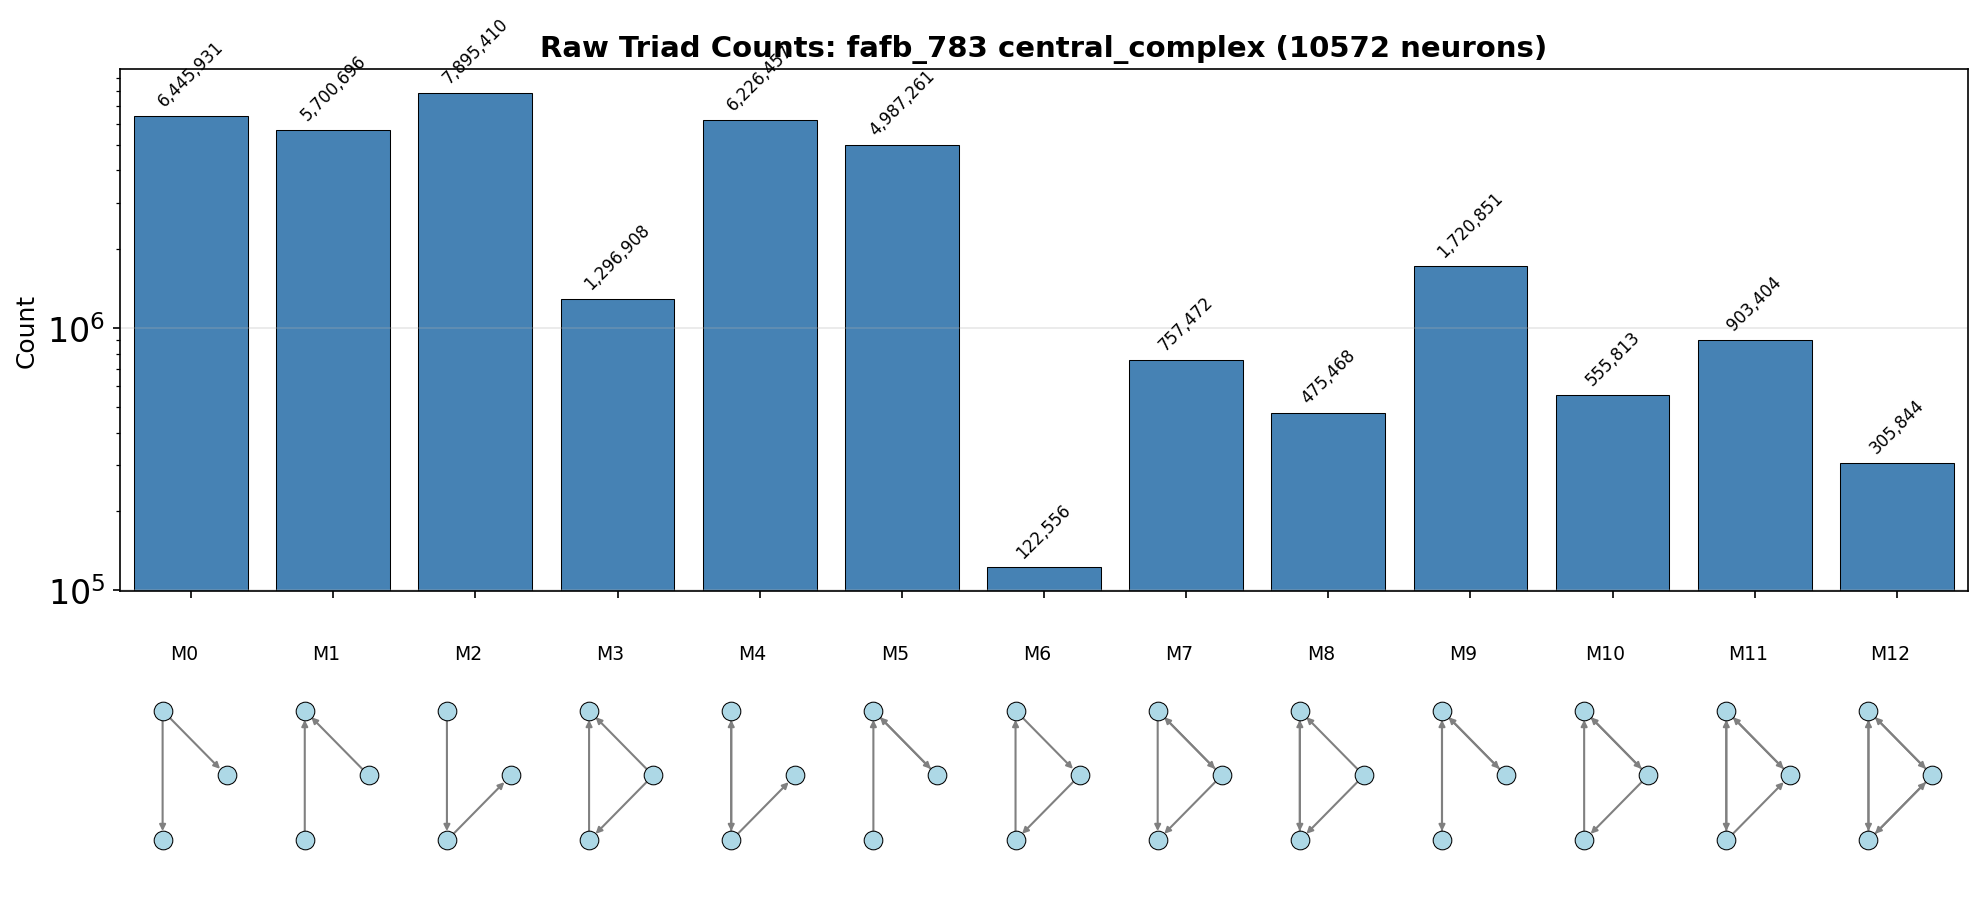


✓ Saved: imgs/fig_connectome_raw_motif_counts.png

⚠️ Remember: Raw counts alone are NOT meaningful for comparison!
   See the significance analysis below for proper interpretation.


In [20]:
# Visualize raw motif counts for the full connectome

if connectome_results['status'] == 'completed':
    counts = connectome_results['counts']
    motif_graphs = connectome_results['motif_graphs']
    
    # Print raw counts table
    print('=' * 60)
    print(f'RAW MOTIF COUNTS: Full Connectome ({G_connectome.number_of_nodes()} nodes)')
    print('=' * 60)
    print(f'{"Motif":<8} {"Count":<15} {"% of Total"}')
    print('-' * 60)
    
    total_motifs = sum(counts)
    for i, c in enumerate(counts):
        if c > 0:
            pct = c / total_motifs * 100
            print(f'M{i:<7} {c:<15,} {pct:>6.2f}%')
    
    print('-' * 60)
    print(f'{"TOTAL":<8} {total_motifs:<15,}')
    
    # Filter to only motifs with counts > 0
    valid_indices = [i for i, c in enumerate(counts) if c > 0]
    valid_counts = [counts[i] for i in valid_indices]
    valid_graphs = [motif_graphs[i] for i in valid_indices]
    
    # Create figure with two rows: bar plot on top, motif graphs below
    fig = plt.figure(figsize=(14, 6))
    
    # Bar plot axes (top portion)
    ax_bar = fig.add_axes([0.08, 0.35, 0.88, 0.58])
    
    bars = ax_bar.bar(range(len(valid_counts)), valid_counts, color='steelblue', 
                       edgecolor='black', linewidth=0.5)
    
    ax_bar.set_ylabel('Count', fontsize=12)
    ax_bar.set_title(f'Raw Triad Counts: {DATASET} {REGION} ({G_connectome.number_of_nodes()} neurons)', 
                     fontsize=14, fontweight='bold')
    
    # Add count labels on bars
    for bar, count in zip(bars, valid_counts):
        height = bar.get_height()
        ax_bar.annotate(f'{count:,}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=8, rotation=45)
    
    ax_bar.set_yscale('log')
    ax_bar.grid(True, alpha=0.3, axis='y')
    ax_bar.set_xticks(range(len(valid_counts)))
    ax_bar.set_xticklabels([])  # Hide x-tick labels, we'll draw graphs instead
    ax_bar.set_xlim(-0.5, len(valid_counts) - 0.5)
    
    # Draw motif graphs below the bar plot
    graph_height = 0.12
    graph_width = 0.88 / len(valid_graphs)
    
    for i, G_motif in enumerate(valid_graphs):
        # Create small axes for each motif graph
        ax_motif = fig.add_axes([0.08 + i * graph_width, 0.02, graph_width * 0.9, 0.25])
        
        # Draw the motif graph
        pos = nx.circular_layout(G_motif)
        nx.draw(G_motif, pos, ax=ax_motif, 
                node_size=80, node_color='lightblue', edgecolors='black', linewidths=0.5,
                arrows=True, arrowsize=6, edge_color='gray', width=1.0,
                with_labels=False)
        ax_motif.set_xlim(-1.5, 1.5)
        ax_motif.set_ylim(-1.5, 1.5)
        ax_motif.axis('off')
        ax_motif.set_title(f'M{valid_indices[i]}', fontsize=9, pad=1)
    
    plt.savefig('imgs/fig_connectome_raw_motif_counts.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print('\n✓ Saved: imgs/fig_connectome_raw_motif_counts.png')
    print('\n⚠️ Remember: Raw counts alone are NOT meaningful for comparison!')
    print('   See the significance analysis below for proper interpretation.')
    
else:
    print('Results not available. Check the status in the cell above.')

MOTIF SIGNIFICANCE: Full Connectome (10572 nodes)
Motif    Count      Z-score      p-value      Interpretation
--------------------------------------------------------------------------------
M0       6445931    -417.82      0.0000       UNDER-represented***
M1       5700696    -393.83      0.0000       UNDER-represented***
M2       7895410    -387.04      0.0000       UNDER-represented***
M3       1296908    -99.91       0.0000       UNDER-represented***
M4       6226457    177.99       0.0000       OVER-represented***
M5       4987261    146.52       0.0000       OVER-represented***
M6       122556     -160.35      0.0000       UNDER-represented***
M7       757472     534.72       0.0000       OVER-represented***
M8       475468     334.98       0.0000       OVER-represented***
M9       1720851    544.34       0.0000       OVER-represented***
M10      555813     231.65       0.0000       OVER-represented***
M11      903404     1119.10      0.0000       OVER-represented***
M12      30

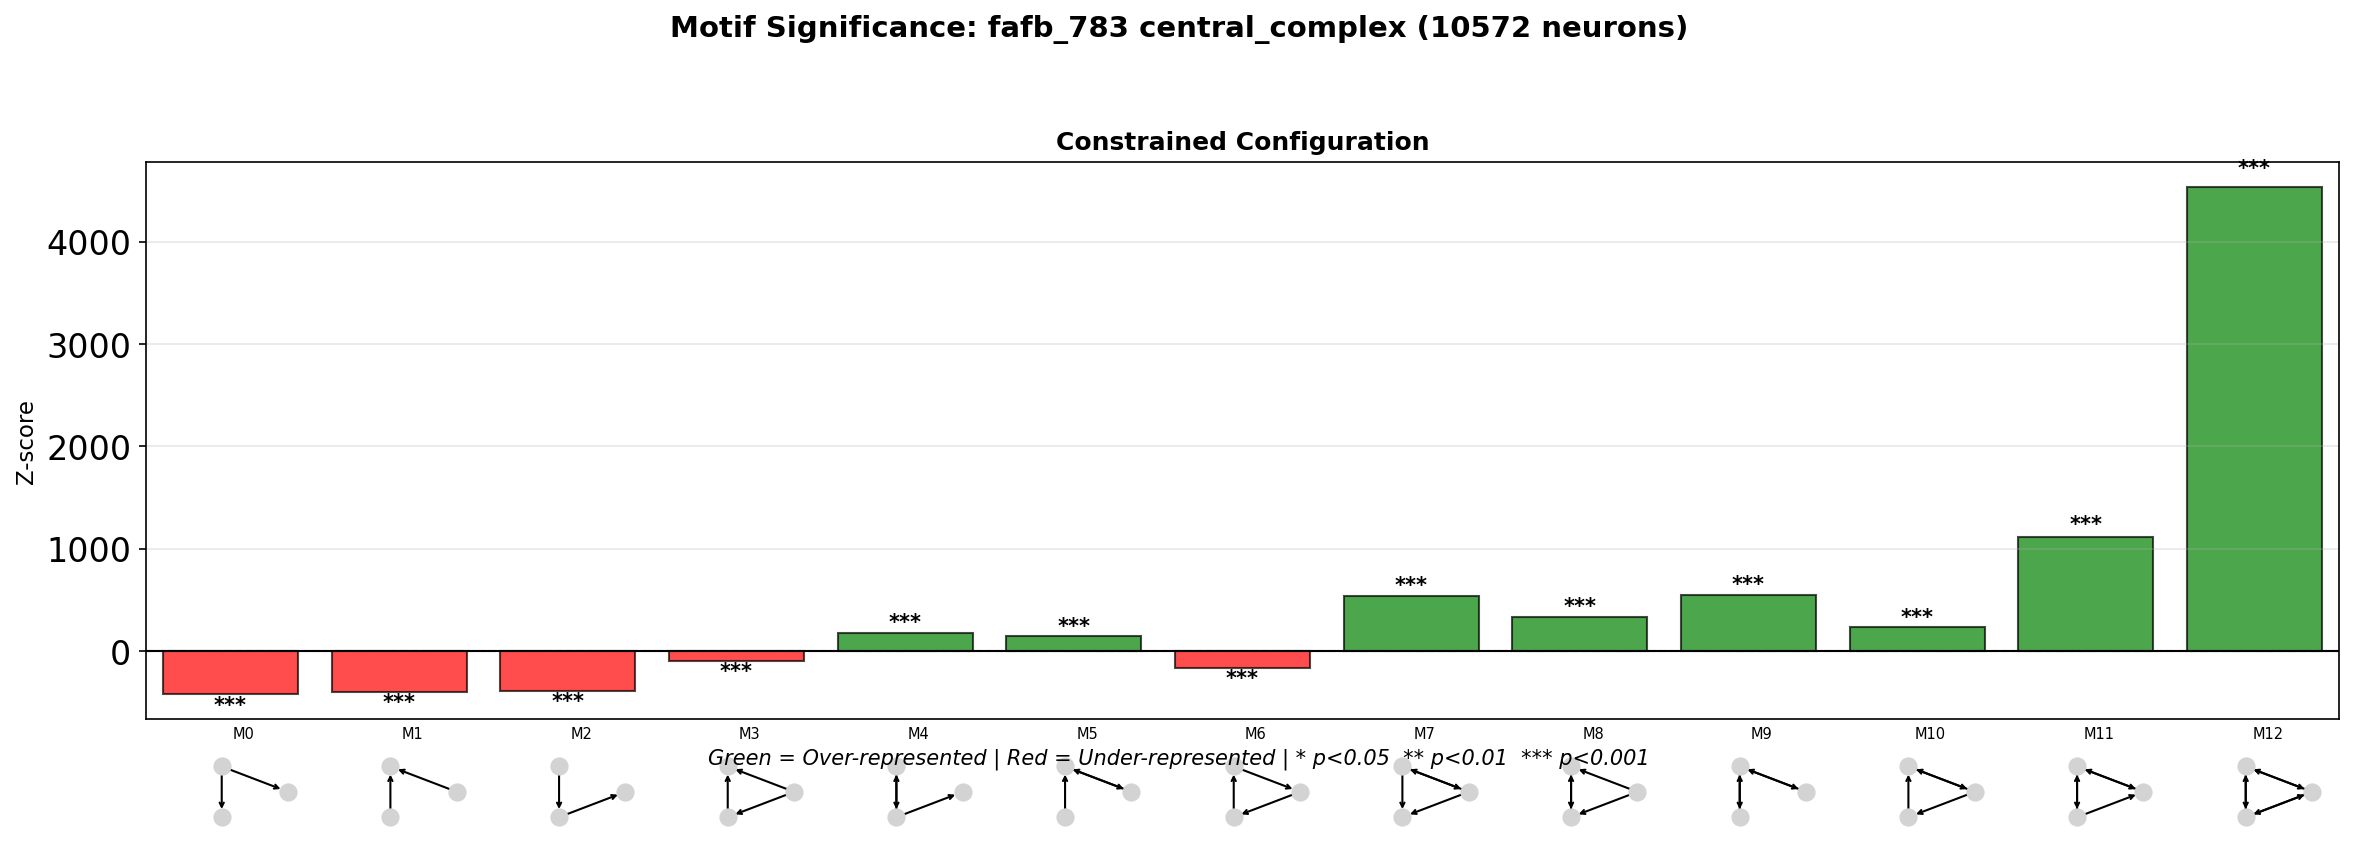


📊 Summary:
   Over-represented motifs (z > 2): 8
   Under-represented motifs (z < -2): 5
   Not significant: 0


In [21]:
# Visualize the full connectome motif significance results

if connectome_results['status'] == 'completed':
    from scipy import stats
    
    z_scores = connectome_results['z_scores']
    counts = connectome_results['counts']
    motif_graphs = connectome_results['motif_graphs']
    
    # Calculate p-values
    p_values = [2 * (1 - stats.norm.cdf(abs(z))) for z in z_scores]
    
    # Print summary table
    print('=' * 80)
    print(f'MOTIF SIGNIFICANCE: Full Connectome ({G_connectome.number_of_nodes()} nodes)')
    print('=' * 80)
    print(f'{"Motif":<8} {"Count":<10} {"Z-score":<12} {"p-value":<12} {"Interpretation"}')
    print('-' * 80)
    
    for i, (z, p, c) in enumerate(zip(z_scores, p_values, counts)):
        if c > 0:  # Only show motifs that appear
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            if z > 2:
                interp = 'OVER-represented' + sig
            elif z < -2:
                interp = 'UNDER-represented' + sig
            else:
                interp = 'not significant'
            print(f'M{i:<7} {c:<10} {z:<12.2f} {p:<12.4f} {interp}')
    
    print('\nSignificance: * p<0.05, ** p<0.01, *** p<0.001')
    
    # Create visualization
    results_dict = {
        'constrained-configuration': {
            i: {'z_score': z, 'p_value': p, 'observed': int(c)}
            for i, (z, p, c) in enumerate(zip(z_scores, p_values, counts))
            if c > 0
        }
    }
    
    from plots import plot_motif_significance
    
    fig = plot_motif_significance(
        results_dict,
        motif_graphs,
        title=f'Motif Significance: {DATASET} {REGION} ({G_connectome.number_of_nodes()} neurons)',
        figsize=(16, 5)
    )
    
    plt.savefig('imgs/fig_connectome_motif_significance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Interpretation
    n_over = sum(1 for z in z_scores if z > 2)
    n_under = sum(1 for z in z_scores if z < -2)
    
    print('\n📊 Summary:')
    print(f'   Over-represented motifs (z > 2): {n_over}')
    print(f'   Under-represented motifs (z < -2): {n_under}')
    print(f'   Not significant: {len([z for z in z_scores if abs(z) <= 2])}')
    
else:
    print('Results not available. Check the status in the cell above.')

## 3.5 Summary

### What We Learned

1. **Isomorphism** (motifs) grow exponentially with the number of nodes
2. **Raw Counts** are meaningless without proper null model comparison
3. **Non-uniform Sampling**: rewiring may create biased samples if not mixed well (MCMC) |